In [15]:
import numpy as np
import pandas as pd
import time
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm

main_folder_path = '/Users/indigobrownhall/Code/pyssem/pyssem'

sys.path.append(main_folder_path) 
import utils.drag.drag
importlib.reload(utils.drag.drag)
from utils.drag.drag import *

def propagate_keplerian(input_oe, param):
    """
    Propagates the orbital elements using Kepler's equation.
    
    Args:
        input_oe (numpy.ndarray): Initial orbital elements [a, e, i, RAAN, omega, M].
        param (dict): Dictionary containing parameters like mu, t, and t_0.
    
    Returns:
        numpy.ndarray: Propagated orbital elements [a, e, i, RAAN, omega, M].
    """
    mu = param['mu']
    t = param['t']
    t_0 = param['t_0']
    deg = np.pi/180

    # Extract initial orbital elements
    a = input_oe[:, 0]
    e = input_oe[:, 1]
    i = input_oe[:, 2]
    RAAN = input_oe[:, 3]
    omega = input_oe[:, 4]
    M0 = input_oe[:, 5]

    # Mean motion
    n = np.sqrt(mu) * a**(-3/2)

    M_no_wrap = M0 + n * (t - t_0)  # Mean anomaly at time t
    # M = M_no_wrap
    # if M_no_wrap > 2 * np.pi:
    M = np.mod(M_no_wrap, 2 * np.pi)  # Wrap to [0, 2*pi]
    # else: 
    #     M = M_no_/wrap

    # Update orbital elements
    propagated_oe = np.column_stack([a, e, i, RAAN, omega, M]) #np.mod(nu, 2 * np.pi)])
    return propagated_oe

def analytic_prop_vec_MOD(input_oe, param):
    # mean orbital elements propagation

    errors = np.zeros((input_oe.shape[0], 1))

    re = param['req']
    J2 = param['j2']
    mu = param['mu']

    a_0 = input_oe[:, 0]
    rho_0 = param['rho']
    C_0 = np.maximum(0.5 * param['Bstar'] * rho_0, 1e-20) # Corrected Bstar usage
    k2_over_mu = J2 * re**2 / 2  # k2 = mu*J2*re^2/2

    t = param['t']
    t_0 = param['t_0']

    e_0 = input_oe[:, 1]
    inc_0 = input_oe[:, 2]
    bigO_0 = input_oe[:, 3]
    omega_0 = input_oe[:, 4]
    Mo_0 = input_oe[:, 5]

    c = np.cos(inc_0)
    c_sq = c**2

    n_0 = np.sqrt(mu) * a_0**(-3/2)

    alpha0_sq = (e_0 / np.sqrt(a_0))**2

    beta_0 = (np.sqrt(3)/2) * e_0

    tan_atan_beta0 = np.maximum(np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0)), 0)
    # aaa = np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0))
    # print(f"tan_atan_beta0: {aaa[0]:.15f}")
    a = (a_0 / beta_0**2) * tan_atan_beta0**2
    e = (2/np.sqrt(3)) * tan_atan_beta0

    check_beta = beta_0 == 0
    print(beta_0)
    if np.any(check_beta):  # Avoid a=NaN when beta_0=0
        a0_beta = a_0[check_beta]
        a[check_beta] = a0_beta * (1 - C_0[check_beta] * n_0[check_beta] * a0_beta * (t - t_0))

    # Compute some variables to avoid repetition of operations
    a_sq = a**2
    four_thirds_over_a_cb = 4/3 / (a_sq * a)
    a0_sq = a_0**2
    four_thirds_over_a0_cb = 4/3 / (a0_sq * a_0)
    alpha0sq_over_asq = alpha0_sq / a_sq
    alpha0sq_over_a0sq = alpha0_sq / a0_sq

    # orig: 
    # Mo = ( (0.5/a - 0.5/a_0) + 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0
    Mo = ( -(0.5/a - 0.5/a_0) - 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0

    # orig: 
    # five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0
    five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0

    omega = 3*k2_over_mu/16 * (5*c_sq - 1) * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + omega_0

    bigO = -3*k2_over_mu/8 * c * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + bigO_0

    out_oe = np.column_stack([a, e, np.mod(inc_0, 2*np.pi), np.mod(bigO, 2*np.pi), np.mod(omega, 2*np.pi), np.mod(Mo, 2*np.pi)])

    not_real = ~np.isreal(inc_0) | ~np.isreal(bigO) | ~np.isreal(omega) | ~np.isreal(Mo)
    errors[not_real] = 1

    out_oe[not_real, :] = input_oe[not_real, :]

    return out_oe, errors

def analytic_propagation_vec(input_oe, param):
    # mean orbital elements propagation

    errors = np.zeros((input_oe.shape[0], 1))

    re = param['req']
    J2 = param['j2']
    mu = param['mu']

    a_0 = input_oe[:, 0]
    a_minus_re = a_0-re

    # if param['density_profile'] == 'jb2008':
    #     1
        # <<< from matlab, to adjust for SSEM 
        # rho = JB2008_dens_func(t, self.R0_km, self.density_data, self.date_mapping, self.nearest_altitude_mapping)
        # >>>
        # rho_0 = zeros(length(a_0),1);
        # check_above = a_minus_re>param.alt(end,1);
        # check_below = a_minus_re<param.alt(1,1);
        # check_in_range = ~check_above & ~check_below;
        # rho_0(check_in_range) = lininterp2_vec_v2(param.alt(:,1),param.dens_times(1,:),param.dens_value,a_minus_re(check_in_range), param.jd)*1e9;
        # rho_0(check_above) = lininterp1_vec(param.dens_times(1,:),param.dens_value(end,:),param.jd)*1e9;
        # rho_0(check_below) = lininterp1_vec(param.dens_times(1,:),param.dens_value(1,:),param.jd)*1e9;
    # elif param['density_profile'] == 'static':
        # rho_0 = densityexp_vec(a_minus_re)*1e9 # kg/km^3 (conversion is: [kg/m^3] or *1e9 [kg/km^3])
    rho_0 = densityexp(a_minus_re)*1e9 # kg/km^3
    # rho_0 = 1.944192087333296e-06  # kg/km^3

    C_0 = np.maximum(0.5 * param['Bstar'] * rho_0, 1e-20) # Corrected Bstar usage
    k2_over_mu = J2 * re**2 / 2  # k2 = mu*J2*re^2/2

    t = param['t']
    t_0 = param['t_0']

    e_0 = input_oe[:, 1]
    inc_0 = input_oe[:, 2]
    bigO_0 = input_oe[:, 3]
    omega_0 = input_oe[:, 4]
    Mo_0 = input_oe[:, 5]

    c = np.cos(inc_0)
    c_sq = c**2

    n_0 = np.sqrt(mu) * a_0**(-3/2)

    alpha0_sq = (e_0 / np.sqrt(a_0))**2

    beta_0 = (np.sqrt(3)/2) * e_0

    tan_atan_beta0 = np.maximum(np.tan(np.arctan(beta_0) - beta_0 * n_0 * a_0 * C_0 * (t - t_0)), 0)
    a = (a_0 / beta_0**2) * tan_atan_beta0**2
    e = (2/np.sqrt(3)) * tan_atan_beta0

    check_beta = beta_0 == 0
    if np.any(check_beta):  # Avoid a=NaN when beta_0=0
        a0_beta = a_0[check_beta]
        a[check_beta] = a0_beta * (1 - C_0[check_beta] * n_0[check_beta] * a0_beta * (t - t_0))

    # Compute some variables to avoid repetition of operations
    a_sq = a**2
    four_thirds_over_a_cb = 4/3 / (a_sq * a)
    a0_sq = a_0**2
    four_thirds_over_a0_cb = 4/3 / (a0_sq * a_0)
    alpha0sq_over_asq = alpha0_sq / a_sq
    alpha0sq_over_a0sq = alpha0_sq / a0_sq

    # orig: 
    Mo = ( (0.5/a - 0.5/a_0) + 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0
    # Mo = ( -(0.5/a - 0.5/a_0) - 3/8 * alpha0_sq * np.log(a/a_0) ) / C_0 + 3*k2_over_mu/16*(3*c_sq-1) * (1.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0 + Mo_0

    # orig: 
    five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * (alpha0sq_over_asq - alpha0sq_over_a0sq) + (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0
    # five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 = (2.5 * - (alpha0sq_over_asq - alpha0sq_over_a0sq) - (four_thirds_over_a_cb - four_thirds_over_a0_cb) ) / C_0

    omega = 3*k2_over_mu/16 * (5*c_sq - 1) * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + omega_0

    bigO = -3*k2_over_mu/8 * c * five_a0sq_over2_tau2_plus_4thirds_over_tau3_over_C0 + bigO_0

    out_oe = np.column_stack([a, e, np.mod(inc_0, 2*np.pi), np.mod(bigO, 2*np.pi), np.mod(omega, 2*np.pi), np.mod(Mo, 2*np.pi)])

    not_real = ~np.isreal(inc_0) | ~np.isreal(bigO) | ~np.isreal(omega) | ~np.isreal(Mo)
    errors[not_real] = 1

    out_oe[not_real, :] = input_oe[not_real, :]

    return out_oe, errors

def osc2mean_m_vec(x, param, theta_osc=None):
    """
    Converts osculating orbital elements (with mean anomaly) to mean
    orbital elements (with mean anomaly) using a vectorized approach
    and the underlying osc2mean_vec function (which presumably uses true anomaly).

    Args:
        x (numpy.ndarray): Array of osculating orbital elements.
                           Shape (N, 6) where N is the number of states.
                           x[:, 0] = osc semimajor axis (kilometers)
                           x[:, 1] = osc orbital eccentricity (non-dimensional)
                           x[:, 2] = osc orbital inclination (radians)
                           x[:, 3] = osc right ascension of ascending node (radians)
                           x[:, 4] = osc argument of perigee (radians)
                           x[:, 5] = osc mean anomaly (radians)
        param (object or dict): Parameters required by the underlying
                                osc2mean_vec function (e.g., J2, R_earth, mu).
                                This needs to be defined based on how
                                `osc2mean_vec` is implemented.
        theta_osc (numpy.ndarray, optional): Osculating true anomaly (radians).
                                            Shape (N,). If None, it will be
                                            calculated from mean anomaly.
                                            Defaults to None.

    Returns:
        tuple:
            - mean_orbital_elements (numpy.ndarray): Array of mean orbital elements.
              Shape (N, 6).
              Elements are: [a_mean, e_mean, i_mean, RAAN_mean, argp_mean, M_mean]
            - theta_mean (numpy.ndarray): Mean true anomaly (radians). Shape (N,).
            - E_mean (numpy.ndarray): Mean eccentric anomaly (radians). Shape (N,).
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1) # Ensure x is 2D for consistent indexing

    if theta_osc is None:
        # Convert from mean anomaly to true anomaly using Newton's method for Kepler's Eq.
        e_osc = x[:, 1]
        M_osc = x[:, 5] # Osculating mean anomaly
        E_osc = M_osc.copy()  # Initial guess for eccentric anomaly

        for _ in range(1000): # Max 100 iterations, typically converges much faster
            f = E_osc - e_osc * np.sin(E_osc) - M_osc
            f_prime = 1.0 - e_osc * np.cos(E_osc)
            delta_E = f / f_prime
            E_osc -= delta_E
            if np.all(np.abs(delta_E) < 1e-14): # Check for convergence
                break
        else: # Executed if the loop completes without break
            print("Warning: Newton's method for eccentric anomaly did not converge for all elements.")

        # Using the formula from MATLAB code:
        # Avoid issues with tan(E/2) when E/2 = pi/2 + k*pi
        # This can happen if E = pi, 3pi, etc.
        # If E = pi, M = pi. If M = pi, E=pi is a solution.
        # tan(pi/2) is undefined.
        # It's generally safer to use arctan2 form if possible.
        # However, to match MATLAB, we'll try this way first:
        sqrt_ep1_em1 = np.sqrt((1.0 + e_osc) / (1.0 - e_osc))
        theta_osc_calc = 2.0 * np.arctan(sqrt_ep1_em1 * np.tan(E_osc / 2.0))
        # Ensure theta_osc is in [0, 2*pi) range, np.arctan gives [-pi/2, pi/2]
        # So 2*atan gives [-pi, pi]. We need to adjust this.
        theta_osc_calc = np.mod(theta_osc_calc, 2*np.pi) # Puts it in [0, 2pi]
        theta_osc_input = theta_osc_calc
    else:
        theta_osc_input = np.asarray(theta_osc)
        if theta_osc_input.ndim == 0: # Scalar
            theta_osc_input = np.array([theta_osc_input])

    # Prepare input for osc2mean_vec: [a_osc, e_osc, i_osc, RAAN_osc, argp_osc, theta_osc_input]
    input_for_o2m_vec = np.column_stack((x[:, 0:5], theta_osc_input))
    oemean_with_theta = osc2mean_vec(input_for_o2m_vec, param)

    a_mean = oemean_with_theta[:, 0]
    e_mean = oemean_with_theta[:, 1]
    i_mean = oemean_with_theta[:, 2]
    RAAN_mean = oemean_with_theta[:, 3]
    argp_mean = oemean_with_theta[:, 4]
    theta_mean_calc = oemean_with_theta[:, 5]

    sqrt_term_inv = np.sqrt((1.0 - e_mean) / (1.0 + e_mean))
    E_mean_calc = 2.0 * np.arctan(sqrt_term_inv * np.tan(theta_mean_calc / 2.0))
    E_mean_calc = np.mod(E_mean_calc, 2 * np.pi) # Ensure E_mean is in [0, 2pi)

    # Compute mean Mean Anomaly (M_mean) from mean eccentric anomaly (E_mean_calc)
    M_mean_calc = E_mean_calc - e_mean * np.sin(E_mean_calc)
    M_mean_calc = np.mod(M_mean_calc, 2 * np.pi) # Ensure M_mean is in [0, 2pi)

    mean_orbital_elements = np.column_stack((a_mean, e_mean, i_mean,
                                             RAAN_mean, argp_mean, M_mean_calc))

    return mean_orbital_elements, theta_mean_calc, E_mean_calc

def osc2mean_vec(oeosc, param):
    """
    Converts osculating classical orbital elements to mean classical orbital elements,
    accounting for J2 secular and long-period perturbations.

    Args:
        oeosc (np.ndarray): Array of osculating orbital elements.
                            Shape (N, 6).
                            oeosc[:,0] = osc semimajor axis (kilometers)
                            oeosc[:,1] = osc orbital eccentricity (non-dimensional)
                            oeosc[:,2] = osc orbital inclination (radians)
                            oeosc[:,3] = osc right ascension of ascending node (radians)
                            oeosc[:,4] = osc argument of perigee (radians)
                            oeosc[:,5] = osc true anomaly (radians)
        param (dict): Dictionary containing parameters:
                      'req': Earth's equatorial radius (kilometers)
                      'j2': J2 gravitational coefficient (non-dimensional)
                      'mu': Earth's gravitational parameter (km^3/s^2) (optional, for kepler if needed)


    Returns:
        np.ndarray: Array of mean orbital elements. Shape (N, 6).
                    oemean[:,0] = mean semimajor axis
                    oemean[:,1] = mean orbital eccentricity
                    oemean[:,2] = mean orbital inclination
                    oemean[:,3] = mean right ascension of ascending node
                    oemean[:,4] = mean argument of perigee
                    oemean[:,5] = mean true anomaly
    """
    oeosc = np.asarray(oeosc)
    if oeosc.ndim == 1:
        oeosc = oeosc.reshape(1, -1)

    req = param['req']
    j2 = param['j2']

    pi2 = 2.0 * np.pi

    aos = oeosc[:, 0]
    eos = oeosc[:, 1]
    ios = oeosc[:, 2]
    ranos = oeosc[:, 3]
    apos = oeosc[:, 4]
    # In the MATLAB code, oeosc(:,6) is M (mean anomaly), but the comments say true anomaly.
    # The first few lines convert M to eanom (eccentric anomaly).
    # So, the input oeosc[:,5] in MATLAB was Mean Anomaly, not True Anomaly as per the top comments.
    # This script assumes the 6th element is TRUE ANOMALY as per the *input* docstring for oeosc.
    # If the 6th input element is MEAN ANOMALY, it needs to be converted to TRUE ANOMALY first.
    # The MATLAB code takes M (oeosc(:,6)) and calculates eanom, then maos.
    # Let's assume the input oeosc[:,5] is true anomaly (theta_osc) as per the docstring.
    # If it's mean anomaly (M_osc), we need this conversion first:
    # _, theta_osc = kepler1_vec_tanom(oeosc[:,5], eos) # If oeosc[:,5] is M_osc
    theta_osc = oeosc[:,5] # If oeosc[:,5] is already theta_osc

    # Convert true anomaly to eccentric anomaly
    cos_E = (eos + np.cos(theta_osc)) / (1.0 + eos * np.cos(theta_osc))
    # Ensure cos_E is within [-1, 1] due to potential floating point inaccuracies
    cos_E = np.clip(cos_E, -1.0, 1.0)
    eanom = np.arccos(cos_E)
    eanom[theta_osc > np.pi] = 2 * np.pi - eanom[theta_osc > np.pi] # Correct quadrant for E
    eanom = np.mod(eanom, pi2)

    # Mean anomaly from eccentric anomaly
    maos = np.mod(eanom - eos * np.sin(eanom), pi2)

    si2 = np.sin(ios)**2
    aa = 1.0/3.0 - 0.5 * si2
    bb = 0.5 * si2

    oemean = np.zeros_like(oeosc)

    # --- Case 1: Low eccentricity (eos < 0.01) ---
    check_e_low = eos < 0.01
    
    if np.any(check_e_low):
        aos_e = aos[check_e_low]
        eos_e = eos[check_e_low]
        ios_e = ios[check_e_low]
        ranos_e = ranos[check_e_low]
        apos_e = apos[check_e_low]
        maos_e = maos[check_e_low]
        bb_e_arr = bb[check_e_low] # Renamed from bb_e to avoid conflict

        lamos = np.mod(maos_e + apos_e, pi2)
        zos = eos_e * np.cos(apos_e)
        etaos = eos_e * np.sin(apos_e)

        # Initialize mean elements for this subset
        am_e = aos_e.copy()
        # lamm, zm, etam will be updated in the loop
        
        threej2req2 = 3.0 * j2 * req**2

        for _ in range(5): # Iteration loop
            # Precompute common terms for this iteration
            sl = np.sin(lamos) # Using lamos from previous iteration or initial
            cl = np.cos(lamos)
            s2l = np.sin(2 * lamos)
            c2l = np.cos(2 * lamos)
            s3l = np.sin(3 * lamos)
            c3l = np.cos(3 * lamos)

            asp_e_iter = threej2req2 / am_e * (bb_e_arr * c2l + (1.0 - 3.5 * bb_e_arr) * \
                           zos * cl + (1.0 - 2.5 * bb_e_arr) * etaos * sl + 3.5 * bb_e_arr * \
                           (zos * c3l + etaos * s3l))
            am_e = aos_e - asp_e_iter # Update am_e based on original aos_e
            am2_e = am_e**2
            
            threej2req2_over2_am2 = (threej2req2 / 2.0) / am2_e

            isp_e_iter = threej2req2_over2_am2 / 4.0 * np.sin(2 * ios_e) * \
                       (c2l - zos * cl + etaos * sl + (7.0/3.0) * (zos * c3l + etaos * s3l))
            im_e_iter = ios_e - isp_e_iter # Update based on original ios_e
            
            # Update terms dependent on im_e_iter for next iteration or for final use in this one
            ci = np.cos(im_e_iter)
            bb_e_arr = 0.5 * np.sin(im_e_iter)**2 # This bb_e_arr is now based on im_e_iter

            ransp_e_iter = threej2req2_over2_am2 * ci * \
                         (0.5 * s2l - 3.5 * zos * sl + 2.5 * etaos * cl + \
                          (7.0/6.0) * (zos * s3l - etaos * c3l))
            ranm_e_iter = ranos_e - ransp_e_iter # Update based on original ranos_e

            lamsp_iter = threej2req2_over2_am2 * \
                       (-0.5 * (1.0 - 5.0 * bb_e_arr) * s2l + \
                        (7.0 - (77.0/4.0) * bb_e_arr) * zos * sl - \
                        (6.0 - (55.0/4.0) * bb_e_arr) * etaos * cl - \
                        (7.0/6.0 - (77.0/12.0) * bb_e_arr) * (zos * s3l - etaos * c3l))
            lamos = np.mod(maos_e + apos_e - lamsp_iter, pi2) # Update lamos for next iteration

            s4l = np.sin(4 * lamos)
            c4l = np.cos(4 * lamos)

            zsp_iter = threej2req2_over2_am2 * \
                     ((1.0 - 2.5 * bb_e_arr) * cl + (7.0/6.0) * bb_e_arr * c3l + \
                      (1.5 - 5.0 * bb_e_arr) * zos * c2l + \
                      (2.0 - 3.0 * bb_e_arr) * etaos * s2l + \
                      (17.0/4.0) * bb_e_arr * (zos * c4l + etaos * s4l))
            zos = eos_e * np.cos(apos_e) - zsp_iter # Update zos for next iteration

            etasp_iter = threej2req2_over2_am2 * \
                       ((1.0 - 3.5 * bb_e_arr) * sl + (7.0/6.0) * bb_e_arr * s3l + \
                        (1.0 - 6.0 * bb_e_arr) * zos * s2l - \
                        (1.5 - 4.0 * bb_e_arr) * etaos * c2l + \
                        (17.0/4.0) * bb_e_arr * (zos * s4l - etaos * c4l))
            etaos = eos_e * np.sin(apos_e) - etasp_iter # Update etaos for next iteration
            
        # After loop, assign final values
        final_am_e = am_e
        final_im_e = im_e_iter
        final_ranm_e = ranm_e_iter
        final_zm = zos # zos was updated with zsp
        final_etam = etaos # etaos was updated with etasp

        em_e = np.sqrt(final_etam**2 + final_zm**2)
        apm_e = np.zeros_like(em_e)
        check_em_gt_eps = em_e > 1.0e-8
        apm_e[check_em_gt_eps] = np.arctan2(final_etam[check_em_gt_eps], final_zm[check_em_gt_eps])
        apm_e = np.mod(apm_e, pi2)

        mam_e = np.mod(lamos - apm_e, pi2) # lamos is the final updated lamm

        oemean[check_e_low, 0] = final_am_e
        oemean[check_e_low, 1] = em_e
        oemean[check_e_low, 2] = final_im_e
        oemean[check_e_low, 3] = final_ranm_e
        oemean[check_e_low, 4] = apm_e
        # The 6th element is mean true anomaly, calculated at the end for all.
        # Store mean mean anomaly for now.
        oemean[check_e_low, 5] = mam_e # Storing M_mean temporarily

    # --- Case 2: Higher eccentricity (eos >= 0.01) ---
    check_e_high = ~check_e_low
    
    if np.any(check_e_high):
        aos_note = aos[check_e_high]
        eos_note = eos[check_e_high]
        ios_note = ios[check_e_high]
        apos_note = apos[check_e_high]
        ranos_note = ranos[check_e_high]
        maos_note = maos[check_e_high] # Original mean anomaly for this subset
        theta_osc_note = theta_osc[check_e_high] # Original true anomaly for this subset

        aa_note_arr = aa[check_e_high] # Renamed
        bb_note_arr = bb[check_e_high] # Renamed

        # Initialize mean elements for iteration
        am_note = aos_note.copy()
        em_note = eos_note.copy()
        im_note = ios_note.copy()
        apm_note = apos_note.copy()
        mam_note = maos_note.copy() # This will be iterated upon
        ranm_note = ranos_note.copy() # This will be iterated upon
        
        # Initial true anomaly corresponding to initial mam_note and em_note
        _, tam_note_iter = kepler1_vec_tanom(mam_note, em_note)

        threej2req2 = 3.0 * j2 * req**2

        for _ in range(5):
            em_note2 = em_note**2
            one_minus_emnote = 1.0 - em_note2
            # Handle division by zero for e=1, though input e < 1
            one_minus_emnote = np.where(one_minus_emnote <= 0, 1e-15, one_minus_emnote)


            pm_note = am_note * one_minus_emnote
            hm = pm_note / (1.0 + em_note * np.cos(tam_note_iter))
            um = np.mod(apm_note + tam_note_iter, pi2)
            cos2um = np.cos(2 * um)
            sin2um = np.sin(2 * um)

            asp_note_iter = (threej2req2 / am_note) * \
                          (((am_note / hm)**3 * (aa_note_arr + bb_note_arr * cos2um)) - \
                           aa_note_arr * one_minus_emnote**(-1.5))
            am_note = aos_note - asp_note_iter # Update based on original aos_note

            isp_note_iter = (threej2req2 / (8.0 * pm_note**2)) * np.sin(2 * im_note) * \
                          (cos2um + em_note * np.cos(tam_note_iter + 2 * apm_note) + \
                           (1.0/3.0) * em_note * np.cos(3 * tam_note_iter + 2 * apm_note))
            im_note = ios_note - isp_note_iter # Update based on original ios_note

            si2_enote = np.sin(im_note)**2 # Using updated im_note
            aa_note_arr = 1.0/3.0 - 0.5 * si2_enote
            bb_note_arr = 0.5 * si2_enote

            # Avoid division by zero for em_note if it becomes zero
            em_note_safe = np.where(np.abs(em_note) < 1e-15, 1e-15, em_note)

            esp_note_iter = (threej2req2 / (2.0 * am_note**2)) * \
                          ((one_minus_emnote / em_note_safe * \
                            (((am_note / hm)**3 * (aa_note_arr + bb_note_arr * cos2um)) - \
                             aa_note_arr * one_minus_emnote**(-1.5))) - \
                           (bb_note_arr / (em_note_safe * one_minus_emnote)) * \
                           (cos2um + em_note * np.cos(tam_note_iter + 2 * apm_note) + \
                            em_note * np.cos(3 * tam_note_iter + 2.0 * apm_note) / 3.0))
            em_note = eos_note - esp_note_iter # Update based on original eos_note
            
            # Recompute dependent terms for next iteration or for final use
            em_note2 = em_note**2
            one_minus_emnote = 1.0 - em_note2
            one_minus_emnote = np.where(one_minus_emnote <= 0, 1e-15, one_minus_emnote)
            pm_note = am_note * one_minus_emnote
            hm = pm_note / (1.0 + em_note * np.cos(tam_note_iter)) # tam_note_iter from previous step
            
            eqoc = np.zeros_like(mam_note)
            # check_tam condition from MATLAB
            is_critical_angle = ( (np.abs(tam_note_iter - np.pi) <= 1.0e-06) | \
                                  (np.abs(mam_note - np.pi) <= 1.0e-06) | \
                                  (np.abs(tam_note_iter) <= 1.0e-06) | \
                                  (np.abs(mam_note) <= 1.0e-06) )
            eqoc[~is_critical_angle] = tam_note_iter[~is_critical_angle] - mam_note[~is_critical_angle]
            
            threej2req2_over2pm2 = (threej2req2 / 2.0) / pm_note**2

            ransp_note_iter = -threej2req2_over2pm2 * np.cos(im_note) * \
                            (eqoc + em_note * np.sin(tam_note_iter) - 0.5 * sin2um - \
                             0.5 * em_note * np.sin(tam_note_iter + 2 * apm_note) - \
                             (1.0/6.0) * em_note * np.sin(3 * tam_note_iter + 2 * apm_note))
            ranm_note = ranos_note - ransp_note_iter # Update based on original ranos_note

            # Again, use em_note_safe for division
            em_note_safe = np.where(np.abs(em_note) < 1e-15, 1e-15, em_note)

            apsp_iter = threej2req2_over2pm2 * \
                      ((2.0 - 5.0 * bb_note_arr) * (eqoc + em_note * np.sin(tam_note_iter)) + \
                       (1.0 - 3.0 * bb_note_arr) * ((1.0 - 0.25 * em_note2) * np.sin(tam_note_iter) / em_note_safe + \
                                                 0.5 * np.sin(2 * tam_note_iter) + em_note * np.sin(3 * tam_note_iter) / 12.0) - \
                       (0.5 * bb_note_arr + (0.5 - 15.0/8.0 * bb_note_arr) * em_note2) / em_note_safe * np.sin(tam_note_iter + 2 * apm_note) + \
                       em_note / 8.0 * bb_note_arr * np.sin(tam_note_iter - 2 * apm_note) - \
                       0.5 * (1.0 - 5.0 * bb_note_arr) * sin2um + \
                       (7.0/6.0 * bb_note_arr - (1.0/6.0) * em_note2 * (1.0 - 19.0/4.0 * bb_note_arr)) / em_note_safe * np.sin(3 * tam_note_iter + 2 * apm_note) + \
                       0.75 * bb_note_arr * np.sin(4 * tam_note_iter + 2 * apm_note) + \
                       em_note / 8.0 * bb_note_arr * np.sin(5 * tam_note_iter + 2 * apm_note))
            apm_note = apos_note - apsp_iter # Update based on original apos_note

            masp_iter = threej2req2_over2pm2 * np.sqrt(one_minus_emnote) / em_note_safe * \
                      (-(1.0 - 3.0 * bb_note_arr) * ((1.0 - em_note2 / 4.0) * np.sin(tam_note_iter) + \
                                                  em_note / 2.0 * np.sin(2 * tam_note_iter) + \
                                                  em_note2 / 12.0 * np.sin(3 * tam_note_iter)) + \
                       bb_note_arr * (0.5 * (1.0 + 1.25 * em_note2) * np.sin(tam_note_iter + 2 * apm_note) - \
                                   em_note2 / 8.0 * np.sin(tam_note_iter - 2 * apm_note) - \
                                   (7.0/6.0) * (1.0 - em_note2 / 28.0) * np.sin(3 * tam_note_iter + 2 * apm_note) - \
                                   0.75 * em_note * np.sin(4 * tam_note_iter + 2 * apm_note) - \
                                   em_note2 / 8.0 * np.sin(5 * tam_note_iter + 2 * apm_note)))
            mam_note = maos_note - masp_iter # Update based on original maos_note

            # Update true anomaly for the next iteration
            _, tam_note_iter = kepler1_vec_tanom(mam_note, em_note)
        
        # After loop, assign final values from this branch
        oemean[check_e_high, 0] = am_note
        oemean[check_e_high, 1] = em_note
        oemean[check_e_high, 2] = im_note
        oemean[check_e_high, 3] = ranm_note
        oemean[check_e_high, 4] = np.mod(apm_note, pi2)
        oemean[check_e_high, 5] = np.mod(mam_note, pi2) # Storing M_mean temporarily

    # --- Combine and calculate final mean true anomaly ---
    # At this point, oemean[:,5] contains the mean MEAN anomaly for all cases.
    final_M_mean = oemean[:, 5]
    final_e_mean = oemean[:, 1]
    _, final_theta_mean = kepler1_vec_tanom(final_M_mean, final_e_mean)
    oemean[:, 5] = final_theta_mean # Replace M_mean with theta_mean

    return oemean

def kepler1_vec_tanom(manom, ecc):
    """
    Solves Kepler's equation for circular, elliptic, and hyperbolic orbits
    using Danby's method (a third-order Newton-Raphson like iteration).

    Args:
        manom (np.ndarray): Mean anomaly (radians).
        ecc (np.ndarray): Orbital eccentricity (non-dimensional).

    Returns:
        tuple:
            - eanom (np.ndarray): Eccentric anomaly (radians) for elliptic orbits,
                                  or hyperbolic eccentric anomaly for hyperbolic orbits.
            - tanom (np.ndarray): True anomaly (radians).
    """
    manom = np.asarray(manom)
    ecc = np.asarray(ecc)

    if manom.shape != ecc.shape:
        if manom.size == 1 and ecc.size > 1:
            manom = np.full_like(ecc, manom.item())
        elif ecc.size == 1 and manom.size > 1:
            ecc = np.full_like(manom, ecc.item())
        else:
            raise ValueError("manom and ecc must have the same shape or one must be a scalar.")

    # Define convergence criterion
    ktol = 1.0e-10
    pi2 = 2.0 * np.pi

    # Normalize mean anomaly to [0, 2*pi)
    xma = manom - pi2 * np.floor(manom / pi2)
    # Or use np.mod(manom, pi2) if you are sure manom is always positive.
    # fix in MATLAB truncates towards zero. floor for positive numbers is the same.
    # If manom can be negative, np.fmod might be closer to MATLAB's fix for negative numbers,
    # but for anomalies, usually positive or wrapped to [0, 2pi] is expected.
    # Let's assume manom is typically positive or wrapped to positive range before this.
    # If not, use xma = np.fmod(manom, pi2); xma[xma < 0] += pi2;

    tanom = np.zeros_like(ecc)
    eanom = np.zeros_like(ecc)

    # --- Initial Guesses ---
    # Identify orbit types
    check_ecc_0 = (ecc == 0.0)
    check_ecc_lt_1_not_0 = (ecc > 0.0) & (ecc < 1.0) # Elliptic, not circular
    check_ecc_gte_1 = (ecc >= 1.0) # Hyperbolic (or parabolic if == 1)

    # Circular orbit
    if np.any(check_ecc_0):
        tanom[check_ecc_0] = xma[check_ecc_0]
        eanom[check_ecc_0] = xma[check_ecc_0]

    # Elliptic orbit initial guess
    if np.any(check_ecc_lt_1_not_0):
        eanom_ellip = eanom[check_ecc_lt_1_not_0]
        xma_ellip = xma[check_ecc_lt_1_not_0]
        ecc_ellip = ecc[check_ecc_lt_1_not_0]
        # Initial guess for elliptic eccentric anomaly
        eanom[check_ecc_lt_1_not_0] = xma_ellip + 0.85 * np.sign(np.sin(xma_ellip)) * ecc_ellip

    # Hyperbolic orbit initial guess (M_h = e_h * sinh(H) - H)
    if np.any(check_ecc_gte_1):
        eanom_hyp = eanom[check_ecc_gte_1]
        xma_hyp = xma[check_ecc_gte_1]
        ecc_hyp = ecc[check_ecc_gte_1]
        # Ensure argument of log is positive. xma_hyp can be 0.
        # log(1.8) if xma_hyp is 0 is not robust.
        # A common initial guess for H is based on M_h.
        # If M_h is small, H ~ M_h / (e-1). If M_h is large, H ~ ln(2*M_h/e)
        # The MATLAB guess log(2*M/e + 1.8) is an empirical one.
        # We need to handle xma_hyp == 0 case for log.
        # For xma_hyp == 0, H should be 0.
        arg_log = (2.0 * xma_hyp / ecc_hyp) + 1.8
        eanom_init_hyp = np.zeros_like(xma_hyp)
        eanom_init_hyp[xma_hyp > 0] = np.log(arg_log[xma_hyp > 0])
        eanom_init_hyp[xma_hyp == 0] = 0.0 # H=0 for M=0
        eanom[check_ecc_gte_1] = eanom_init_hyp


    # --- Perform Iterations (Danby's method) ---
    niter = 0
    
    # Indices for elements that still need iteration
    # We will create boolean masks for elliptic and hyperbolic cases that need iteration
    iter_mask_ellip = check_ecc_lt_1_not_0.copy()
    iter_mask_hyp = check_ecc_gte_1.copy()

    while np.any(iter_mask_ellip) or np.any(iter_mask_hyp):
        if niter > 20:
            print('\n\n   More than 20 iterations in kepler1_vec_tanom \n\n')
            # In Python, we might raise an exception or return with a warning flag
            # For now, just break, similar to MATLAB returning.
            # The final tanom will be based on the last eanom.
            break

        # --- Elliptic Case ---
        if np.any(iter_mask_ellip):
            eanom_curr_e = eanom[iter_mask_ellip]
            ecc_curr_e = ecc[iter_mask_ellip]
            xma_curr_e = xma[iter_mask_ellip]

            se = ecc_curr_e * np.sin(eanom_curr_e)
            ce = ecc_curr_e * np.cos(eanom_curr_e)

            fe = eanom_curr_e - se - xma_curr_e
            fpe = 1.0 - ce
            fppe = se
            fpppe = ce
            
            # Update eanom for elliptic cases
            delta_e = -fe / fpe
            deltastar_e = -fe / (fpe + 0.5 * delta_e * fppe)
            deltak_e = -fe / (fpe + 0.5 * deltastar_e * fppe + \
                              deltastar_e**2 * fpppe / 6.0)
            eanom[iter_mask_ellip] += deltak_e
            
            # Update mask for elliptic cases: only keep those where |fe| > ktol
            iter_mask_ellip[iter_mask_ellip] = (np.abs(fe) > ktol)


        # --- Hyperbolic Case ---
        if np.any(iter_mask_hyp):
            eanom_curr_h = eanom[iter_mask_hyp]
            ecc_curr_h = ecc[iter_mask_hyp]
            xma_curr_h = xma[iter_mask_hyp]

            sh = ecc_curr_h * np.sinh(eanom_curr_h)
            ch = ecc_curr_h * np.cosh(eanom_curr_h)

            fh = sh - eanom_curr_h - xma_curr_h # M = e*sinh(H) - H => e*sinh(H) - H - M = 0
            fph = ch - 1.0
            fpph = sh
            fppph = ch

            # Update eanom for hyperbolic cases
            # Avoid division by zero if fph is zero (ch=1 => H=0)
            # If H=0, M=0, then fh=0, so delta_h should be 0.
            delta_h = np.zeros_like(fh)
            deltastar_h = np.zeros_like(fh)
            deltak_h = np.zeros_like(fh)

            non_zero_fph = np.abs(fph) > 1e-15 # Avoid division by zero
            
            delta_h[non_zero_fph] = -fh[non_zero_fph] / fph[non_zero_fph]
            
            denom_deltastar = fph + 0.5 * delta_h * fpph
            non_zero_denom_deltastar = np.abs(denom_deltastar) > 1e-15
            deltastar_h[non_zero_denom_deltastar] = -fh[non_zero_denom_deltastar] / denom_deltastar[non_zero_denom_deltastar]
            
            denom_deltak = fph + 0.5 * deltastar_h * fpph + \
                           deltastar_h**2 * fppph / 6.0
            non_zero_denom_deltak = np.abs(denom_deltak) > 1e-15
            deltak_h[non_zero_denom_deltak] = -fh[non_zero_denom_deltak] / denom_deltak[non_zero_denom_deltak]
            
            eanom[iter_mask_hyp] += deltak_h

            # Update mask for hyperbolic cases: only keep those where |fh| > ktol
            iter_mask_hyp[iter_mask_hyp] = (np.abs(fh) > ktol)
            
        niter += 1


    # --- Compute True Anomaly ---
    # Elliptic orbit: tan(theta/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    # More robustly:
    # cos(theta) = (cos(E) - e) / (1 - e*cos(E))
    # sin(theta) = (sqrt(1-e^2)*sin(E)) / (1 - e*cos(E))
    if np.any(check_ecc_lt_1_not_0):
        eanom_f_e = eanom[check_ecc_lt_1_not_0]
        ecc_f_e = ecc[check_ecc_lt_1_not_0]
        
        # Numerically stable way to calculate true anomaly from eccentric anomaly
        cos_tanom_e = (np.cos(eanom_f_e) - ecc_f_e) / (1.0 - ecc_f_e * np.cos(eanom_f_e))
        sin_tanom_e = (np.sqrt(1.0 - ecc_f_e**2) * np.sin(eanom_f_e)) / (1.0 - ecc_f_e * np.cos(eanom_f_e))
        tanom[check_ecc_lt_1_not_0] = np.arctan2(sin_tanom_e, cos_tanom_e)

    # Hyperbolic orbit: tan(theta/2) = sqrt((e+1)/(e-1)) * tanh(H/2)
    # More robustly:
    # cos(theta) = (cosh(H) - e) / (e*cosh(H) - 1) -- careful, this is for e > cosh(H)
    # A common form is:
    # cos(theta) = (e - cosh(H)) / (e*cosh(H) - 1) -> No, this is incorrect
    # Correct: cos(theta) = (ecc_hyp * np.cosh(eanom_f_h) - 1.0) / (ecc_hyp - np.cosh(eanom_f_h))
    # This seems to be for distance. Let's use the standard:
    # cos_theta = (e - cosh(H)) / (e*cosh(H) -1) is incorrect.
    # Vallado 4th ed. Eq 2-29: cos_nu = (e - cosh(H))/(e*cosh(H)-1)
    # Should be: (e - cosh(H)) / (e * cosh(H) - 1) -> No, this for cos(phi) where phi is eccentric longitude.
    # Let's use the formulation from the MATLAB code via `stah` and `ctah`
    # stah = sqrt(ecc(check_ecc_hyp) .* ecc(check_ecc_hyp) - 1) .* sinh(eanom(check_ecc_hyp));
    # ctah = ecc(check_ecc_hyp) - cosh(eanom(check_ecc_hyp));
    # This ctah is actually e - cosh(H) which is -r*cos(nu)*(e^2-1)/p for hyperbolic.
    # And stah is r*sin(nu)*(e^2-1)/p
    # So atan2(stah, ctah) should give nu.
    if np.any(check_ecc_gte_1):
        eanom_f_h = eanom[check_ecc_gte_1]
        ecc_f_h = ecc[check_ecc_gte_1]

        # Ensure e > 1 for sqrt(e^2 - 1)
        # For e=1 (parabolic), this method is not ideal. The original code doesn't special case e=1.
        # If e=1, sqrt will be 0. sinh(H) could be anything.
        # Parabolic case often uses Barker's equation. Danby's method is usually for e!=1.
        # However, the MATLAB code groups e>=1.
        ecc_f_h_safe = np.where(ecc_f_h < 1.0000000001, 1.0000000001, ecc_f_h) # Avoid e=1 issues with sqrt

        stah = np.sqrt(ecc_f_h_safe**2 - 1.0) * np.sinh(eanom_f_h)
        ctah = ecc_f_h_safe - np.cosh(eanom_f_h) # This is e - cosh(H)
        # For true anomaly, the standard relation is:
        # cos_nu = (e - cosh(H)) / (e * cosh(H) - 1) - This is incorrect.
        # cos_nu = (cosh(H) - e) / (1 - e * cosh(H))
        # sin_nu = (sqrt(e^2 - 1) * sinh(H)) / (1 - e * cosh(H))
        # The MATLAB form `atan2(stah, ctah)` implies:
        # tanom = atan2( sqrt(e^2-1)*sinh(H), e - cosh(H) )
        # This form is correct for nu.
        tanom[check_ecc_gte_1] = np.arctan2(stah, ctah)

    # Ensure tanom is in [0, 2*pi)
    tanom = np.mod(tanom, pi2)

    return eanom, tanom

def mean2osc_m_vec(x, param):
    """
    Converts mean orbital elements (with mean anomaly) to osculating
    orbital elements (with mean anomaly) using a vectorized approach
    and an underlying mean2osc_vec function (which presumably uses true anomaly).

    Args:
        x (numpy.ndarray): Array of mean orbital elements.
                           Shape (N, 6) where N is the number of states.
                           x[:, 0] = mean semimajor axis (kilometers)
                           x[:, 1] = mean orbital eccentricity (non-dimensional)
                           x[:, 2] = mean orbital inclination (radians)
                           x[:, 3] = mean right ascension of ascending node (radians)
                           x[:, 4] = mean argument of perigee (radians)
                           x[:, 5] = mean mean anomaly (radians)
        param (object or dict): Parameters required by the underlying
                                mean2osc_vec function (e.g., J2, R_earth, mu).
                                This needs to be defined based on how
                                `mean2osc_vec` is implemented.

    Returns:
        tuple:
            - osc_orbital_elements (numpy.ndarray): Array of osculating orbital elements.
              Shape (N, 6).
              Elements are: [a_osc, e_osc, i_osc, RAAN_osc, argp_osc, M_osc]
            - theta_osc (numpy.ndarray): Osculating true anomaly (radians). Shape (N,).
            - E_osc (numpy.ndarray): Osculating eccentric anomaly (radians). Shape (N,).
    """
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1) # Ensure x is 2D for consistent indexing

    # Convert from mean mean anomaly to mean true anomaly
    e_mean = x[:, 1]
    M_mean = x[:, 5] # Mean mean anomaly
    
    # Solve Kepler's equation: M = E - e*sin(E) for E_mean
    E_mean_calc = M_mean.copy()  # Initial guess for mean eccentric anomaly
    for _ in range(1000): # Max 100 iterations
        f = E_mean_calc - e_mean * np.sin(E_mean_calc) - M_mean
        f_prime = 1.0 - e_mean * np.cos(E_mean_calc)
        delta_E = f / f_prime
        E_mean_calc -= delta_E
        if np.all(np.abs(delta_E) < 1e-14): # Check for convergence
            break
    else: # Executed if the loop completes without break
        print("Warning: Newton's method for mean eccentric anomaly did not converge for all elements.")

    # Calculate mean true anomaly (theta_mean) from mean eccentric anomaly (E_mean_calc)
    # tan(theta/2) = sqrt((1+e)/(1-e)) * tan(E/2)
    sqrt_ep1_em1_mean = np.sqrt((1.0 + e_mean) / (1.0 - e_mean))
    theta_mean_calc = 2.0 * np.arctan(sqrt_ep1_em1_mean * np.tan(E_mean_calc / 2.0))
    theta_mean_calc = np.mod(theta_mean_calc, 2 * np.pi) # Ensure theta_mean is in [0, 2pi)

    # Assume mean2osc_vec is a pre-existing Python function that takes:
    # mean_elements_with_true_anomaly (N, 6) [a_m, e_m, i_m, RAAN_m, argp_m, theta_m]
    # and param
    # and returns osc_elements_with_true_anomaly (N, 6)
    # We need to define or import mean2osc_vec
    # For now, let's create a placeholder:
    if 'mean2osc_vec' not in globals():
        def mean2osc_vec(mean_elements_theta, params_placeholder):
            """Placeholder for the actual mean2osc_vec function."""
            print("Warning: Using placeholder mean2osc_vec. Replace with actual implementation.")
            # This should implement the inverse of osc2mean_vec (e.g., inverse Brouwer-Lyddane)
            # For now, it will just pass through mean, which is incorrect for conversion
            return mean_elements_theta

    # Prepare input for mean2osc_vec: [a_mean, e_mean, i_mean, RAAN_mean, argp_mean, theta_mean_calc]
    input_for_m2o_vec = np.column_stack((x[:, 0:5], theta_mean_calc))
    oeosc_with_theta = mean2osc_vec(input_for_m2o_vec, param)

    a_osc = oeosc_with_theta[:, 0]
    e_osc_calc = oeosc_with_theta[:, 1] # osculating eccentricity
    i_osc = oeosc_with_theta[:, 2]
    RAAN_osc = oeosc_with_theta[:, 3]
    argp_osc = oeosc_with_theta[:, 4]
    theta_osc_calc = oeosc_with_theta[:, 5] # osculating true anomaly

    # Compute the osculating eccentric anomaly (E_osc_calc) from osculating true anomaly (theta_osc_calc)
    # E = 2 * atan(sqrt((1-e)/(1+e)) * tan(theta/2))
    sqrt_term_inv_osc = np.sqrt((1.0 - e_osc_calc) / (1.0 + e_osc_calc))
    E_osc_calc = 2.0 * np.arctan(sqrt_term_inv_osc * np.tan(theta_osc_calc / 2.0))
    E_osc_calc = np.mod(E_osc_calc, 2 * np.pi) # Ensure E_osc is in [0, 2pi)

    # Compute osculating Mean Anomaly (M_osc_calc) from osculating eccentric anomaly (E_osc_calc)
    M_osc_calc = E_osc_calc - e_osc_calc * np.sin(E_osc_calc)
    M_osc_calc = np.mod(M_osc_calc, 2 * np.pi) # Ensure M_osc is in [0, 2pi)

    osc_orbital_elements = np.column_stack((a_osc, e_osc_calc, i_osc,
                                            RAAN_osc, argp_osc, M_osc_calc))

    return osc_orbital_elements, theta_osc_calc, E_osc_calc


In [34]:
########################
# FULL MC PROPAGATION
########################

from tqdm import tqdm
hours = 3600.0
days = 24.0 * hours
years = 365.25 * days  # Julian year
months = years / 12.0
deg = np.pi / 180.0

mu = 398600.0
RE = 6378.136
J2 = 1082.63e-6

i0 = 45.0 * deg
RA0 = 0.0 * deg
w0 = 0.0 * deg
TA0 = 0.0 * deg
A = 1.0 * 1e-6
m = 100.0
cd = 2.2
B = cd * A / m
param = {}
param['req'] = RE
param['j2'] = J2 
param['mu'] = mu
param['Bstar'] = B
param['density_profile'] = 'static'

n_points = 20

sma_max = 2000.0 + RE
sma_min = 200.0 + RE
ecc_max = 0.1
ecc_min = 0.001

semi_major_axis_points = np.linspace(sma_min, sma_max, n_points)
eccentricity_points = np.linspace(ecc_min, ecc_max, n_points)

# import os
print(os.getcwd())
data = pd.read_csv('../launch/data/ref_scen_SEP1.csv')

filtered_data = data[data['obj_type'] == 1].copy()


valid_indices_mask = (filtered_data['sma'] >= sma_min) & \
                     (filtered_data['sma'] <= sma_max) & \
                     (filtered_data['ecc'] >= ecc_min) & \
                     (filtered_data['ecc'] <= ecc_max)
filtered_data = filtered_data[valid_indices_mask]

print(f'length of rocket bodies: {len(filtered_data)}')


sma_points = filtered_data['sma'].values
ecc_points = filtered_data['ecc'].values

time_step = 30.0 * days
total_time = 100.0 * years
years_in_seconds = np.array([10.0, 40.0, 70.0, 100.0]) * years

num_steps_times = np.arange(0, total_time + time_step, time_step) # Ensure total_time is included

num_bodies = len(sma_points)
sma_trajectory = np.zeros((num_bodies, len(num_steps_times)))
ecc_trajectory = np.zeros((num_bodies, len(num_steps_times)))


valid_indices_plot_initial = (sma_points >= sma_min) & (sma_points <= sma_max) & \
                             (ecc_points >= ecc_min) & (ecc_points <= ecc_max)

valid_sma_initial = sma_points[valid_indices_plot_initial]
valid_ecc_initial = ecc_points[valid_indices_plot_initial]

distribution_matrix_initial = np.zeros((n_points, n_points))

for i in range(len(valid_sma_initial)):
    sma_idx = np.argmin(np.abs(semi_major_axis_points - valid_sma_initial[i]))
    ecc_idx = np.argmin(np.abs(eccentricity_points - valid_ecc_initial[i]))
    distribution_matrix_initial[sma_idx, ecc_idx] += 1


start_prop_time = time.time()
for i in tqdm(range(num_bodies), desc="Propagating Rocket Bodies"):
# for i in range(num_bodies):
    input_oe_current = np.array([sma_points[i], ecc_points[i], i0, RA0, w0, TA0])
    # mean_orbital_elements, _, _ = osc2mean_m_vec(input_oe_current, param, TA0) # TA0 is osculating true anomaly
    # input_oe_current = mean_orbital_elements

    # convert input_oe_current to a 2D array for consistency
    input_oe_current = input_oe_current.reshape(1, -1)  # Ensure it's a 2D array

    sma_trajectory[i, 0] = input_oe_current[0][0]
    ecc_trajectory[i, 0] = input_oe_current[0][1]
    # out_oe_body = np.zeros((len(num_steps_times) - 1, 6)) # This was per body in MATLAB, not strictly needed if input_oe_current is updated

    for j in range(len(num_steps_times) - 1):
        if input_oe_current[0][0] * (1 - input_oe_current[0][1]) < RE + 150.0 or input_oe_current[0][0] < 100.0:
            sma_trajectory[i, j + 1:] = -99.0
            ecc_trajectory[i, j + 1:] = -99.0
            # out_oe_body[j,:] = out_oe_body[j-1,:] # If out_oe_body was used
            break
        else:
            param['t_0'] = num_steps_times[j]
            param['t'] = num_steps_times[j + 1]

            out_oe_propagated, _ = analytic_propagation_vec(input_oe_current, param)
            # out_oe_body[j,:] = out_oe_propagated # If out_oe_body was used
            input_oe_current = out_oe_propagated
        
        sma_trajectory[i, j + 1] = input_oe_current[0][0]
        ecc_trajectory[i, j + 1] = input_oe_current[0][1]
end_prop_time = time.time()
print(f"Propagation elapsed time: {end_prop_time - start_prop_time:.2f} seconds")

/Users/indigobrownhall/Code/pyssem/pyssem/utils/notebooks
length of rocket bodies: 862


Propagating Rocket Bodies: 100%|██████████| 862/862 [27:35<00:00,  1.92s/it]    

Propagation elapsed time: 1655.06 seconds


/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/1143418436.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet').copy()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/1143418436.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  (cmap2 := cm.get_cmap('jet').copy()).set_under('white')
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/1143418436.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


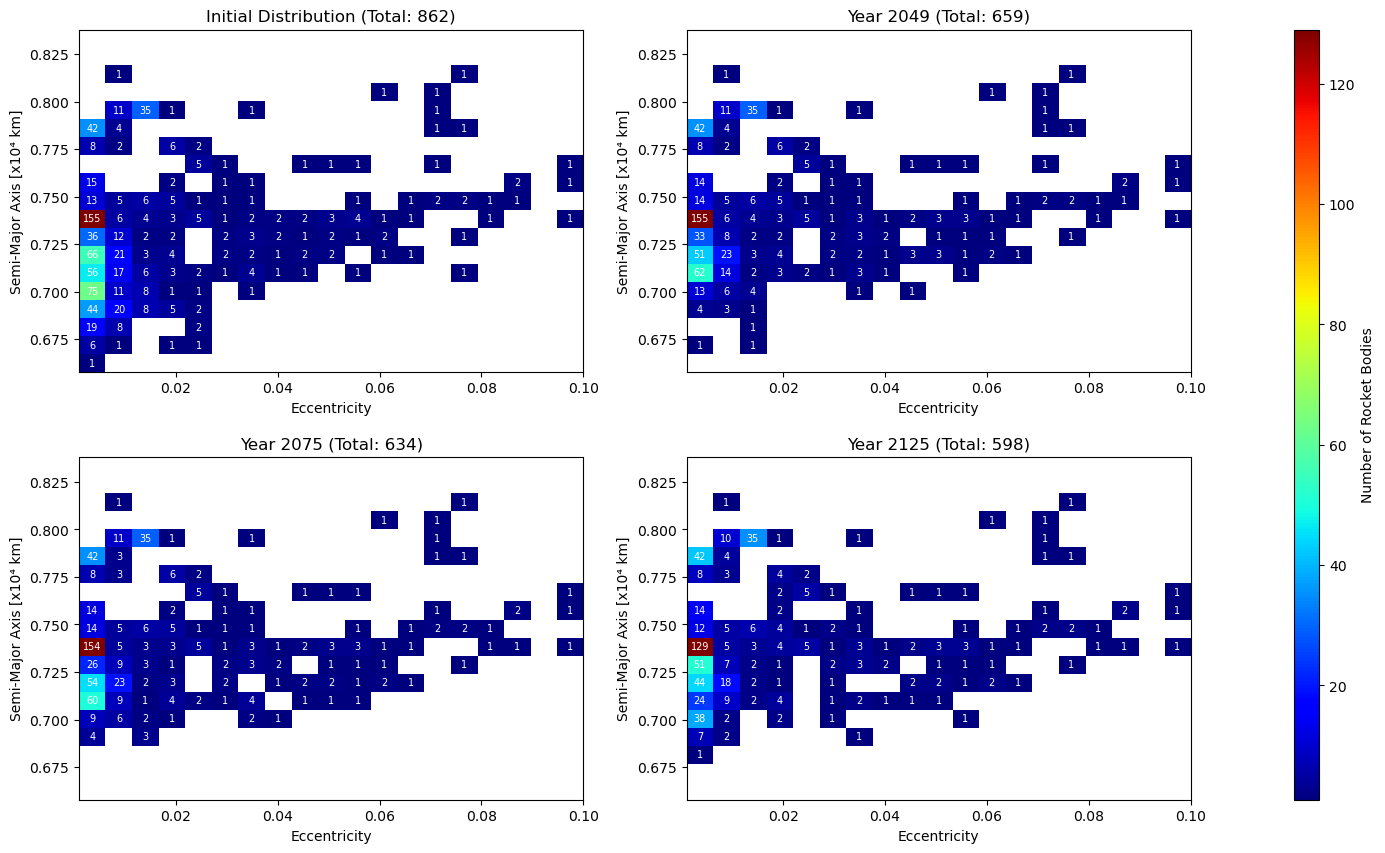

In [17]:
########################
# Distribtuion PLots, this will do it at time fractions

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

# --- Year conversion ---
start_year = 2025
seconds_per_year = 365.25 * 24 * 3600
years = start_year + (np.array(num_steps_times) - num_steps_times[0]) / seconds_per_year

# --- Time steps to show ---
time_fractions = [0.0, 0.25, 0.50, 1.0]
indices = [int(f * (len(num_steps_times) - 1)) for f in time_fractions]
titles = ['Initial Distribution'] + [f'Year {int(years[idx])}' for idx in indices[1:]]

# --- Bin centers for annotation ---
x_centers = 0.5 * (eccentricity_points[:-1] + eccentricity_points[1:])
y_centers = 0.5 * (semi_major_axis_points[:-1] + semi_major_axis_points[1:]) / 10000

# --- Prepare colormap with white for zero ---
from matplotlib import cm
cmap = cm.get_cmap('jet').copy()
cmap.set_under('white')

# --- Plot layout ---
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05], wspace=0.3, hspace=0.25)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
cbar_ax = fig.add_subplot(gs[:, 2])

# --- Plot each panel ---
# --- Plot each panel ---
for plot_idx, idx in enumerate(indices):
    ax = axes[plot_idx]
    sma_vals = sma_trajectory[:, idx]
    ecc_vals = ecc_trajectory[:, idx]
    mask = (sma_vals > 0) & (ecc_vals > 0)
    sma_vals = sma_vals[mask]
    ecc_vals = ecc_vals[mask]
    H_raw, _, _ = np.histogram2d(ecc_vals, sma_vals, bins=[eccentricity_points, semi_major_axis_points])

    # Transpose and mask
    H = H_raw.T
    H_masked = np.ma.masked_where(H == 0, H)

    # Plot
    im = ax.imshow(H_masked, extent=[eccentricity_points[0], eccentricity_points[-1],
                                     semi_major_axis_points[0]/10000, semi_major_axis_points[-1]/10000],
                   origin='lower', aspect='auto', cmap=cmap, vmin=1, interpolation='nearest')

    # Annotated title with total count
    total_bodies = int(np.sum(H))
    ax.set_title(f"{titles[plot_idx]} (Total: {total_bodies})")

    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Semi-Major Axis [x10⁴ km]')

    # Dynamic label contrast
    norm = Normalize(vmin=1, vmax=np.max(H_masked))
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            val = H[i, j]
            if val > 0:
                (cmap2 := cm.get_cmap('jet').copy()).set_under('white')
                luminance = 0.299 * r + 0.587 * g + 0.114 * b
                text_color = 'black' if luminance > 0.5 else 'white'
                ax.text(x_centers[j], y_centers[i], f"{int(val)}",
                        ha='center', va='center', fontsize=7, color=text_color)

# --- Shared colorbar ---
fig.colorbar(im, cax=cbar_ax, label='Number of Rocket Bodies')
plt.tight_layout()
plt.show()

In [18]:
##########################
## Propagation using da/dt
##########################

num_bodies = len(sma_points)
sma_trajectory_da_dt = np.zeros((num_bodies, len(num_steps_times)))
ecc_trajectory_da_dt = np.zeros((num_bodies, len(num_steps_times)))

start_prop_time_da_dt = time.time()
for i in tqdm(range(num_bodies), desc="Propagating Rocket Bodies with da/dt"):
    a = float(sma_points[i])
    e = float(ecc_points[i])

    sma_trajectory_da_dt[i, 0] = a
    ecc_trajectory_da_dt[i, 0] = e

    for j in range(len(num_steps_times) - 1):

        # decay check
        if a * (1 - e) < RE + 150.0 or a < 100.0:
            sma_trajectory_da_dt[i, j + 1:] = -99.0
            ecc_trajectory_da_dt[i, j + 1:] = -99.0
            break

        # constants
        t0, t  = num_steps_times[j], num_steps_times[j + 1]
        dt     = t - t0
        re     = param['req']
        mu     = param['mu']
        n0     = np.sqrt(mu) * a ** -1.5
        beta   = (np.sqrt(3) / 2) * e
        rho0   = densityexp(a - re) * 1e9
        C0     = max(0.5 * param['Bstar'] * rho0, 1e-20)

        # rates
        ang  = np.arctan((np.sqrt(3)/2)*e) - (np.sqrt(3)/2)*e * n0 * a * C0 * dt
        dadt = -(4/np.sqrt(3)) * (a**2 * n0 * C0 / e) * np.tan(ang) / np.cos(ang)**2

        arg  = np.arctan(beta) - beta * n0 * a * C0 * dt
        dedt = -e * n0 * a * C0 / np.cos(arg)**2

        # advance
        a += dadt * dt
        e += dedt * dt

        sma_trajectory_da_dt[i, j + 1] = a
        ecc_trajectory_da_dt[i, j + 1] = e

end_prop_time_da_dt = time.time()
print(f"Propagation with da/dt elapsed time: {end_prop_time_da_dt - start_prop_time_da_dt:.2f} seconds")

Propagating Rocket Bodies with da/dt: 100%|██████████| 862/862 [01:02<00:00, 13.71it/s]

Propagation with da/dt elapsed time: 62.87 seconds


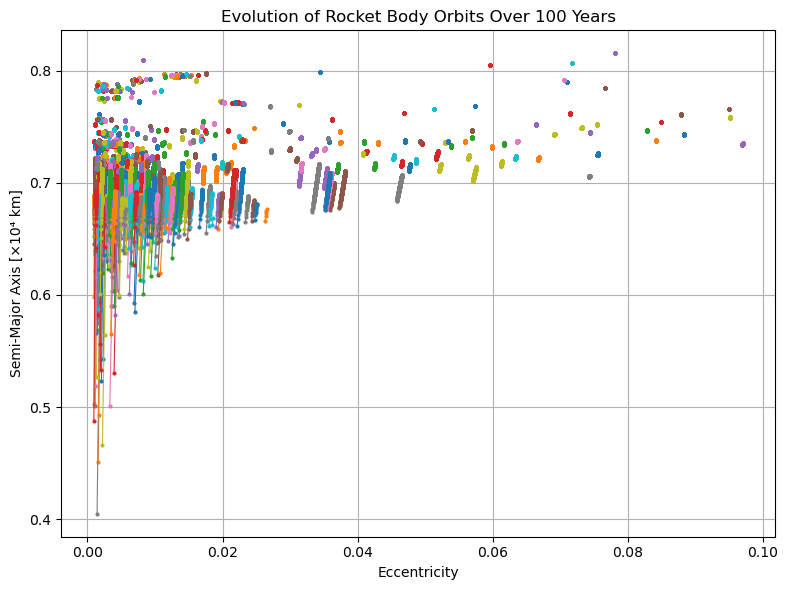

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(sma_trajectory_da_dt.shape[0]):
    valid = (sma_trajectory_da_dt[i] != -99) & (ecc_trajectory_da_dt[i] != -99)
    if valid.any():                       # skip fully–decayed bodies
        ax.plot(
            ecc_trajectory_da_dt[i, valid],
            sma_trajectory_da_dt[i, valid] / 1e4,   # km → ×10⁴ km
            '-o', markersize=2, linewidth=0.8
        )

ax.set_xlabel('Eccentricity')
ax.set_ylabel('Semi-Major Axis [×10⁴ km]')
ax.set_title('Evolution of Rocket Body Orbits Over 100 Years')
ax.grid(True)
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/687249874.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet').copy()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/687249874.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  (cmap2 := cm.get_cmap('jet').copy()).set_under('white')
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/687249874.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


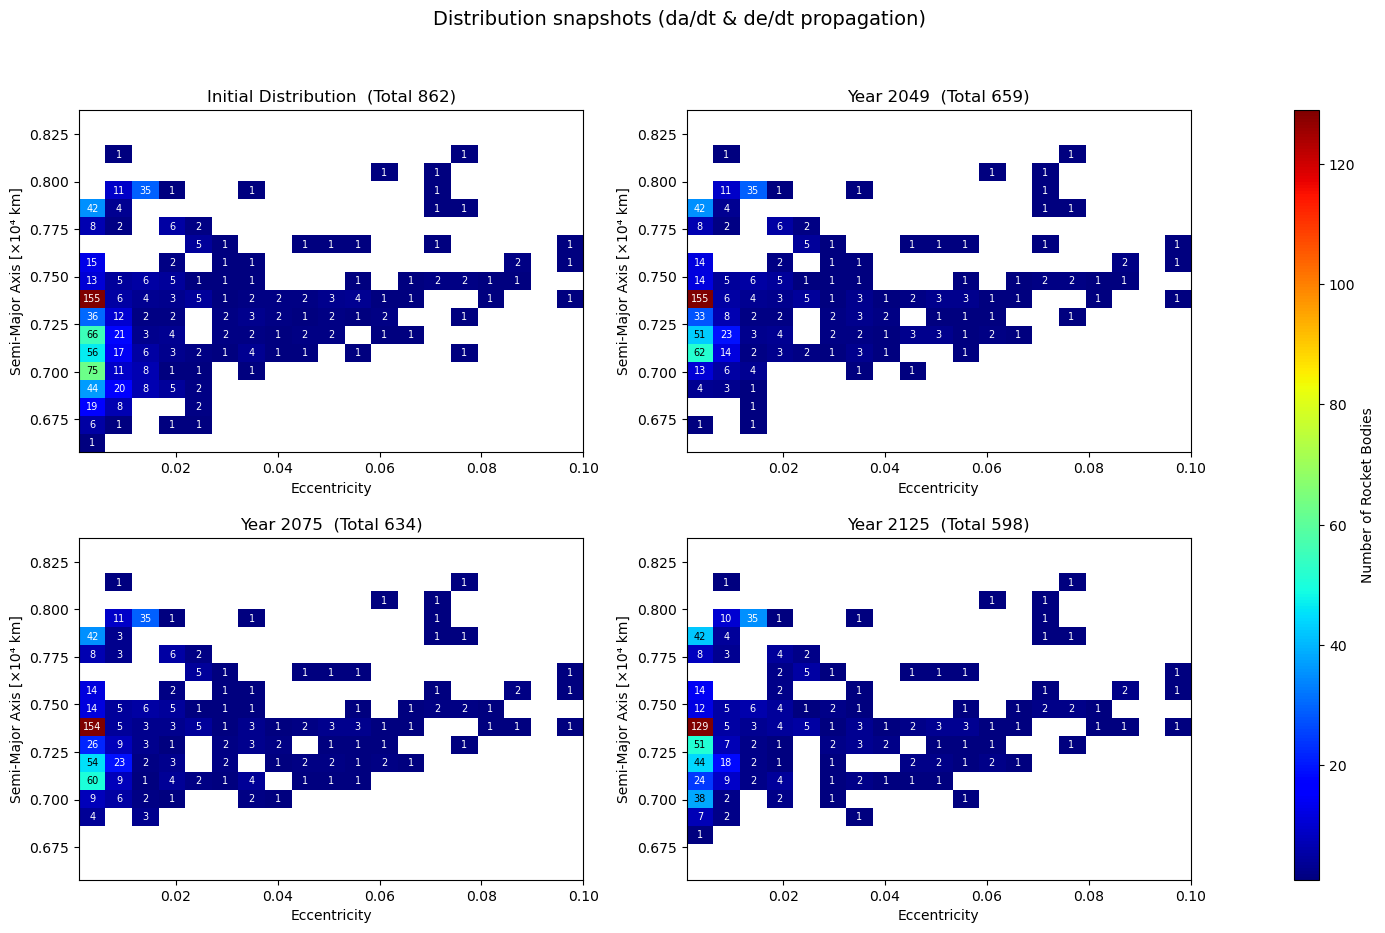

In [20]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np

# ────────────────────────────────────────────────────────────────
# 1. snapshot indices for 0 %, 25 %, 50 %, 100 %
# ────────────────────────────────────────────────────────────────
frac = [0.0, 0.25, 0.50, 1.0]
indices = [int(f * (len(num_steps_times) - 1)) for f in frac]

SECONDS_PER_YEAR = 365.25 * 24 * 3600
calendar_years   = 2025 + (num_steps_times - num_steps_times[0]) / SECONDS_PER_YEAR
titles = ['Initial Distribution'] + [f'Year {int(calendar_years[i])}'
                                     for i in indices[1:]]

# ────────────────────────────────────────────────────────────────
# 2. helpers
# ────────────────────────────────────────────────────────────────
x_centers = eccentricity_points
y_centers = semi_major_axis_points / 1e4   # km → ×10⁴ km

cmap = cm.get_cmap('jet').copy()
cmap.set_under('white')

fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05],
                        wspace=0.3, hspace=0.25)
axes    = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
cbar_ax = fig.add_subplot(gs[:, 2])

# ────────────────────────────────────────────────────────────────
# 3. plot four panels
# ────────────────────────────────────────────────────────────────
for p, idx in enumerate(indices):
    ax = axes[p]
    sma_vals = sma_trajectory_da_dt[:, idx]
    ecc_vals = ecc_trajectory_da_dt[:, idx]

    valid = (sma_vals > 0) & (ecc_vals > 0)
    H_raw, _, _ = np.histogram2d(
        ecc_vals[valid], sma_vals[valid],
        bins=[eccentricity_points, semi_major_axis_points]
    )

    H  = H_raw.T
    Hm = np.ma.masked_where(H == 0, H)

    # choose vmin/vmax so colour-bar never throws
    vmax = H.max() if H.max() > 0 else 1
    vmin = 1 if vmax > 0 else 0

    im = ax.imshow(
        Hm,
        extent=[eccentricity_points[0], eccentricity_points[-1],
                semi_major_axis_points[0]/1e4,  semi_major_axis_points[-1]/1e4],
        origin='lower', aspect='auto',
        cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest'
    )

    ax.set_title(f"{titles[p]}  (Total {H.sum():.0f})")
    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Semi-Major Axis [×10⁴ km]')

    # --- mid-points for text labels (length = n_points-1 = 19) ------------
    x_centers = 0.5 * (eccentricity_points[:-1]        + eccentricity_points[1:])
    y_centers = 0.5 * (semi_major_axis_points[:-1] / 1e4 +  # km → ×10⁴ km
                    semi_major_axis_points[1:]  / 1e4)

    # ---------------------------------------------------------------------
    # adaptive-text loop – use H.shape so you never over-run the matrix
    # ---------------------------------------------------------------------
    for i in range(H.shape[0]):          # rows (a-bins)   → 0 … 18
        for j in range(H.shape[1]):      # cols (e-bins)   → 0 … 18
            val = H[i, j]
            if val:
                (cmap2 := cm.get_cmap('jet').copy()).set_under('white')
                rgba = cmap2(Normalize(vmin=vmin, vmax=vmax)(val))
                r, g, b, _ = rgba
                lum  = 0.299*r + 0.587*g + 0.114*b
                txt_col = 'black' if lum > 0.5 else 'white'
                ax.text(x_centers[j], y_centers[i], f"{int(val)}",
                        ha='center', va='center', fontsize=7, color=txt_col)

# shared colour-bar
fig.colorbar(im, cax=cbar_ax, label='Number of Rocket Bodies')
fig.suptitle('Distribution snapshots (da/dt & de/dt propagation)', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/1364924003.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet').copy()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/1364924003.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


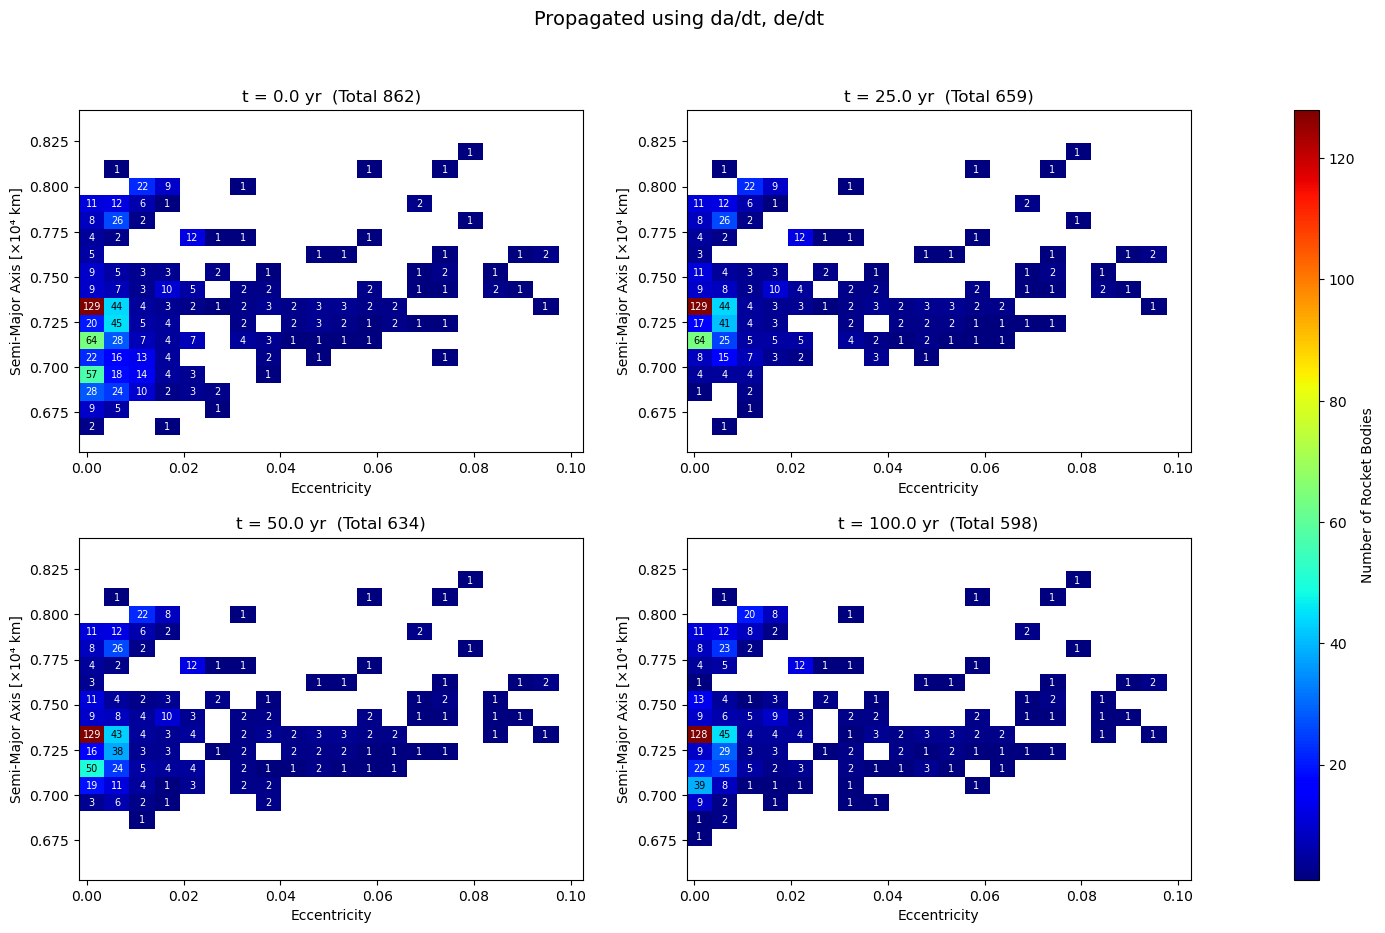

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from matplotlib.colors import Normalize

# ───────────────────────────────────────────────────────────────
# 1. choose snapshot indices (initial, 25 %, 50 %, 100 %)
# ───────────────────────────────────────────────────────────────
time_indices_to_plot = [
    0,
    int(0.25 * (len(num_steps_times) - 1)),
    int(0.50 * (len(num_steps_times) - 1)),
    int(1.00 * (len(num_steps_times) - 1)),
]

SECONDS_PER_YEAR = 365.25 * 24 * 3600
titles = [f"t = {num_steps_times[i]/SECONDS_PER_YEAR:.1f} yr"
          for i in time_indices_to_plot]

# ───────────────────────────────────────────────────────────────
# 2. helpers: bin edges & centres
# ───────────────────────────────────────────────────────────────
dx = eccentricity_points[1]          - eccentricity_points[0]
dy = (semi_major_axis_points[1] - semi_major_axis_points[0]) / 1e4

x_edges = np.concatenate(([eccentricity_points[0] - dx/2],
                          eccentricity_points + dx/2))
y_edges = np.concatenate(([semi_major_axis_points[0]/1e4 - dy/2],
                          semi_major_axis_points/1e4 + dy/2))

x_centres = eccentricity_points
y_centres = semi_major_axis_points / 1e4  # km → ×10⁴ km

# ───────────────────────────────────────────────────────────────
# 3. colormap & layout
# ───────────────────────────────────────────────────────────────
cmap = cm.get_cmap('jet').copy()
cmap.set_under('white')

fig  = plt.figure(figsize=(16, 10))
gs   = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05],
                         wspace=0.3, hspace=0.25)
axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
cbar_ax = fig.add_subplot(gs[:, 2])

# ───────────────────────────────────────────────────────────────
# 4. iterate over snapshots
# ───────────────────────────────────────────────────────────────
for panel, t_idx in enumerate(time_indices_to_plot):
    ax   = axes[panel]
    dist = np.zeros((n_points, n_points), dtype=int)

    # valid objects at this epoch
    mask = (sma_trajectory_da_dt[:, t_idx] != -99) & (ecc_trajectory_da_dt[:, t_idx] != -99)
    sma  = sma_trajectory_da_dt[mask, t_idx]
    ecc  = ecc_trajectory_da_dt[mask, t_idx]

    # nearest-centre binning
    sma_idx = np.abs(semi_major_axis_points[:, None] - sma).argmin(axis=0)
    ecc_idx = np.abs(eccentricity_points[:,     None] - ecc).argmin(axis=0)
    np.add.at(dist, (sma_idx, ecc_idx), 1)

    # mask zeros for white cells
    Hm = np.ma.masked_where(dist == 0, dist)
    vmax = Hm.max() if Hm.count() else 1

    im = ax.imshow(
        Hm,
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        origin='lower', aspect='auto',
        cmap=cmap, vmin=1, vmax=vmax, interpolation='nearest'
    )

    ax.set_title(f"{titles[panel]}  (Total {dist.sum():.0f})")
    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Semi-Major Axis [×10⁴ km]')

    # dynamic text colour
    norm = Normalize(vmin=1, vmax=vmax)
    for i in range(n_points):
        for j in range(n_points):
            val = dist[i, j]
            if val:
                r, g, b, _ = cmap(norm(val))
                lum = 0.299*r + 0.587*g + 0.114*b
                txt_col = 'black' if lum > 0.5 else 'white'
                ax.text(x_centres[j], y_centres[i], str(val),
                        ha='center', va='center', fontsize=7, color=txt_col)

# shared colour-bar
fig.colorbar(im, cax=cbar_ax, label='Number of Rocket Bodies')
fig.suptitle("Propagated using da/dt, de/dt", fontsize=14)
plt.tight_layout()
plt.show()

Flux simulation:  10%|█         | 124/1217 [00:07<01:04, 16.82it/s]

Step 121/1217  t = 9.94 yr   Tot = 739


Flux simulation:  20%|██        | 244/1217 [00:14<00:57, 16.85it/s]

Step 242/1217  t = 19.88 yr   Tot = 698


Flux simulation:  30%|███       | 366/1217 [00:21<00:51, 16.57it/s]

Step 363/1217  t = 29.82 yr   Tot = 674


Flux simulation:  40%|████      | 488/1217 [00:29<00:44, 16.54it/s]

Step 484/1217  t = 39.75 yr   Tot = 658


Flux simulation:  50%|████▉     | 608/1217 [00:36<00:37, 16.31it/s]

Step 605/1217  t = 49.69 yr   Tot = 645


Flux simulation:  60%|█████▉    | 730/1217 [00:43<00:29, 16.45it/s]

Step 726/1217  t = 59.63 yr   Tot = 634


Flux simulation:  70%|██████▉   | 850/1217 [00:51<00:22, 16.42it/s]

Step 847/1217  t = 69.57 yr   Tot = 625


Flux simulation:  80%|███████▉  | 970/1217 [00:58<00:15, 16.46it/s]

Step 968/1217  t = 79.51 yr   Tot = 616


Flux simulation:  90%|████████▉ | 1094/1217 [01:05<00:07, 16.25it/s]

Step 1089/1217  t = 89.45 yr   Tot = 608


Flux simulation: 100%|█████████▉| 1214/1217 [01:13<00:00, 16.41it/s]

Step 1210/1217  t = 99.38 yr   Tot = 601


Flux simulation: 100%|██████████| 1217/1217 [01:13<00:00, 16.55it/s]
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/2011899372.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Step 1217/1217  t = 99.96 yr   Tot = 600


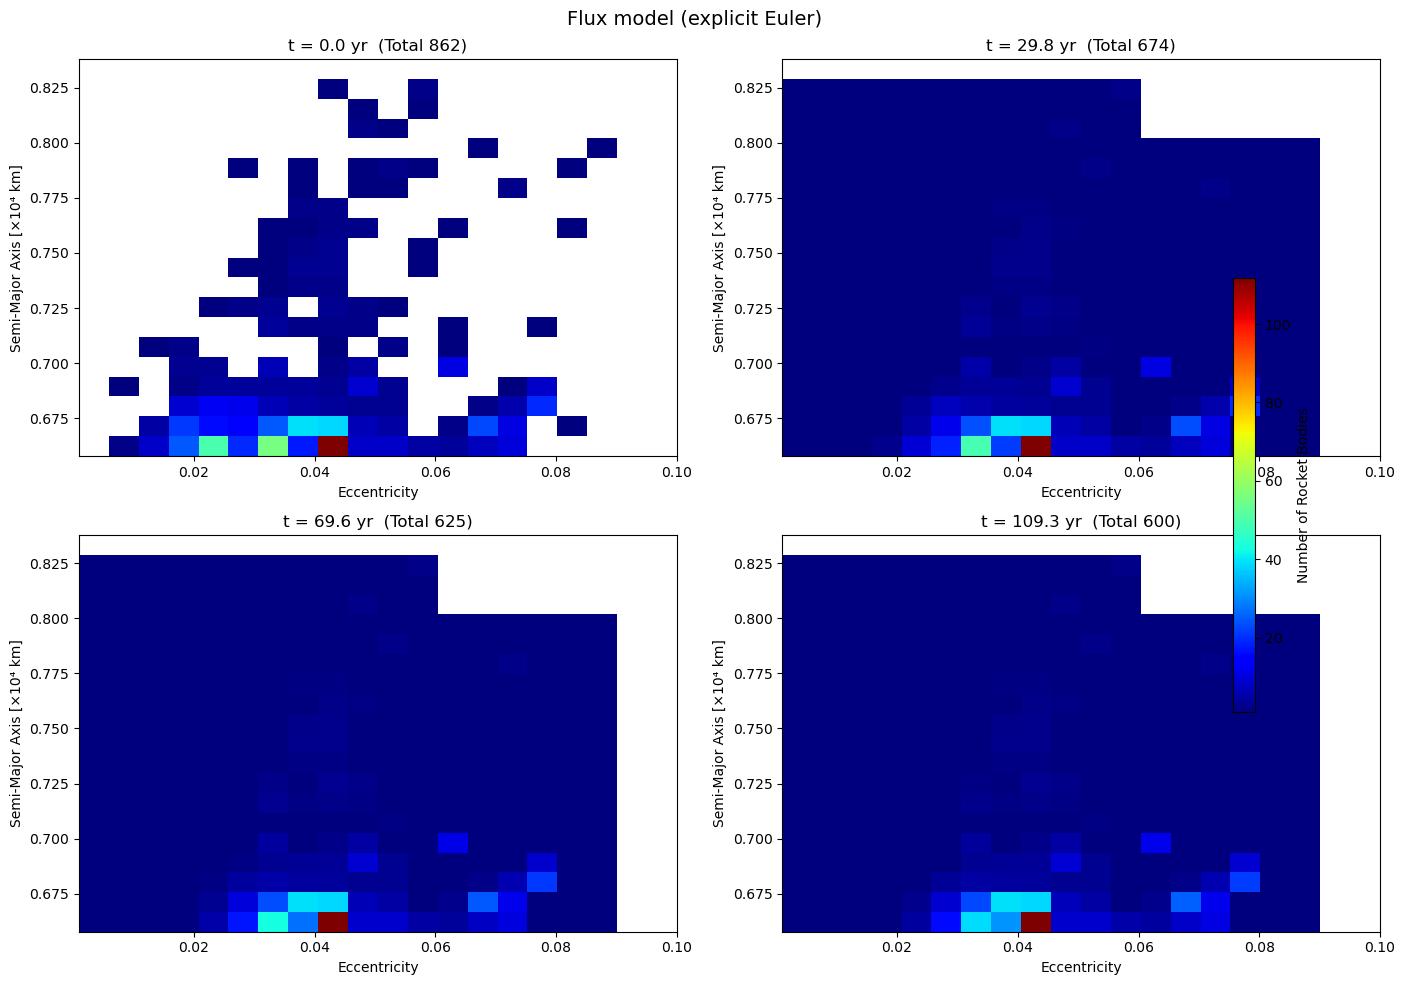

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ────────────────────────────────────────────────────────────────────────
# CONSTANTS / GRIDS THAT MUST ALREADY EXIST
# ────────────────────────────────────────────────────────────────────────
# distribution_matrix_initial : np.ndarray (n_points × n_points)
# semi_major_axis_points      : np.ndarray (n_points)  [km]
# eccentricity_points         : np.ndarray (n_points)
# param = {'req': RE, 'mu': mu, 'Bstar': B}   (all scalars)
# time_step                   : float  [s]
# total_time                  : float  [s]
# densityexp(alt_km)          : function → ρ [kg m⁻³]
# ────────────────────────────────────────────────────────────────────────

# seconds in a Julian year (keep scalar, never overwrite)
SECONDS_PER_YEAR = 365.25 * 24 * 3600

n_points = len(semi_major_axis_points)

# ────────────────────────────────────────────────────────────────────────
# 1.  SUPPORT FUNCTIONS (direct MATLAB → NumPy rewrite)
# ────────────────────────────────────────────────────────────────────────
def get_dadt(a_current: float, e_current: float, p: dict) -> float:
    re   = p['req']
    mu   = p['mu']
    n0   = np.sqrt(mu) * a_current ** -1.5
    e0   = e_current
    a_minus_re = a_current - re
    rho0 = densityexp(a_minus_re) * 1e9  # kg km⁻³
    C0   = max(0.5 * p['Bstar'] * rho0, 1e-20)
    dt   = p['t'] - p['t_0']
    ang  = np.arctan((np.sqrt(3)/2)*e0) - (np.sqrt(3)/2)*e0 * n0 * a_current * C0 * dt
    sec2 = 1.0 / np.cos(ang) ** 2
    return -(4 / np.sqrt(3)) * (a_current**2 * n0 * C0 / e0) * np.tan(ang) * sec2

def get_dedt(a_current: float, e_current: float, p: dict) -> float:
    re   = p['req']
    mu   = p['mu']
    n0   = np.sqrt(mu) * a_current ** -1.5
    beta = (np.sqrt(3)/2) * e_current
    a_minus_re = a_current - re
    rho0 = densityexp(a_minus_re) * 1e9
    C0   = max(0.5 * p['Bstar'] * rho0, 1e-20)
    dt   = p['t'] - p['t_0']
    arg  = np.arctan(beta) - beta * n0 * a_current * C0 * dt
    sec2 = 1.0 / np.cos(arg) ** 2
    return -e_current * n0 * a_current * C0 * sec2

# ────────────────────────────────────────────────────────────────────────
# 2.  FLUX MODEL (explicit Euler, a–e grid)
# ────────────────────────────────────────────────────────────────────────
N       = distribution_matrix_initial.copy().astype(float)
Δa      = semi_major_axis_points[1] - semi_major_axis_points[0]
Δe      = eccentricity_points[1]    - eccentricity_points[0]
dt      = time_step
num_ts  = int(total_time // dt)

N_hist  = [N.copy()]
store_every = max(1, num_ts // 10)

for step in tqdm(range(1, num_ts + 1), desc="Flux simulation"):
    param['t_0'] = (step - 1) * dt
    param['t']   = step * dt

    # --- adot, edot arrays ---
    adot = np.zeros_like(N)
    edot = np.zeros_like(N)
    for r in range(n_points):
        a_val = semi_major_axis_points[r]
        for c in range(n_points):
            e_val      = eccentricity_points[c]
            adot[r, c] = get_dadt(a_val, e_val, param)
            edot[r, c] = get_dedt(a_val, e_val, param)

    # --- upwind fluxes ---
    dN = np.zeros_like(N)
    for r in range(n_points - 1, -1, -1):
        for c in range(n_points - 1, -1, -1):
            Nrc = N[r, c]
            out_a = Nrc * adot[r, c] * dt / Δa
            out_e = Nrc * edot[r, c] * dt / Δe

            # limiter
            total_out = out_a + out_e
            if abs(total_out) > Nrc and Nrc > 0:
                factor = Nrc / abs(total_out)
                out_a *= factor
                out_e *= factor

            dN[r, c] += out_a + out_e
            if r > 0: dN[r-1, c]   -= out_a
            if c > 0: dN[r, c-1]   -= out_e

    N += dN

    if step % store_every == 0 or step == num_ts:
        N_hist.append(N.copy())
        yrs = step * dt / SECONDS_PER_YEAR
        print(f"Step {step}/{num_ts}  t = {yrs:.2f} yr   Tot = {N.sum():.0f}")

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/140444026.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet').copy()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/140444026.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


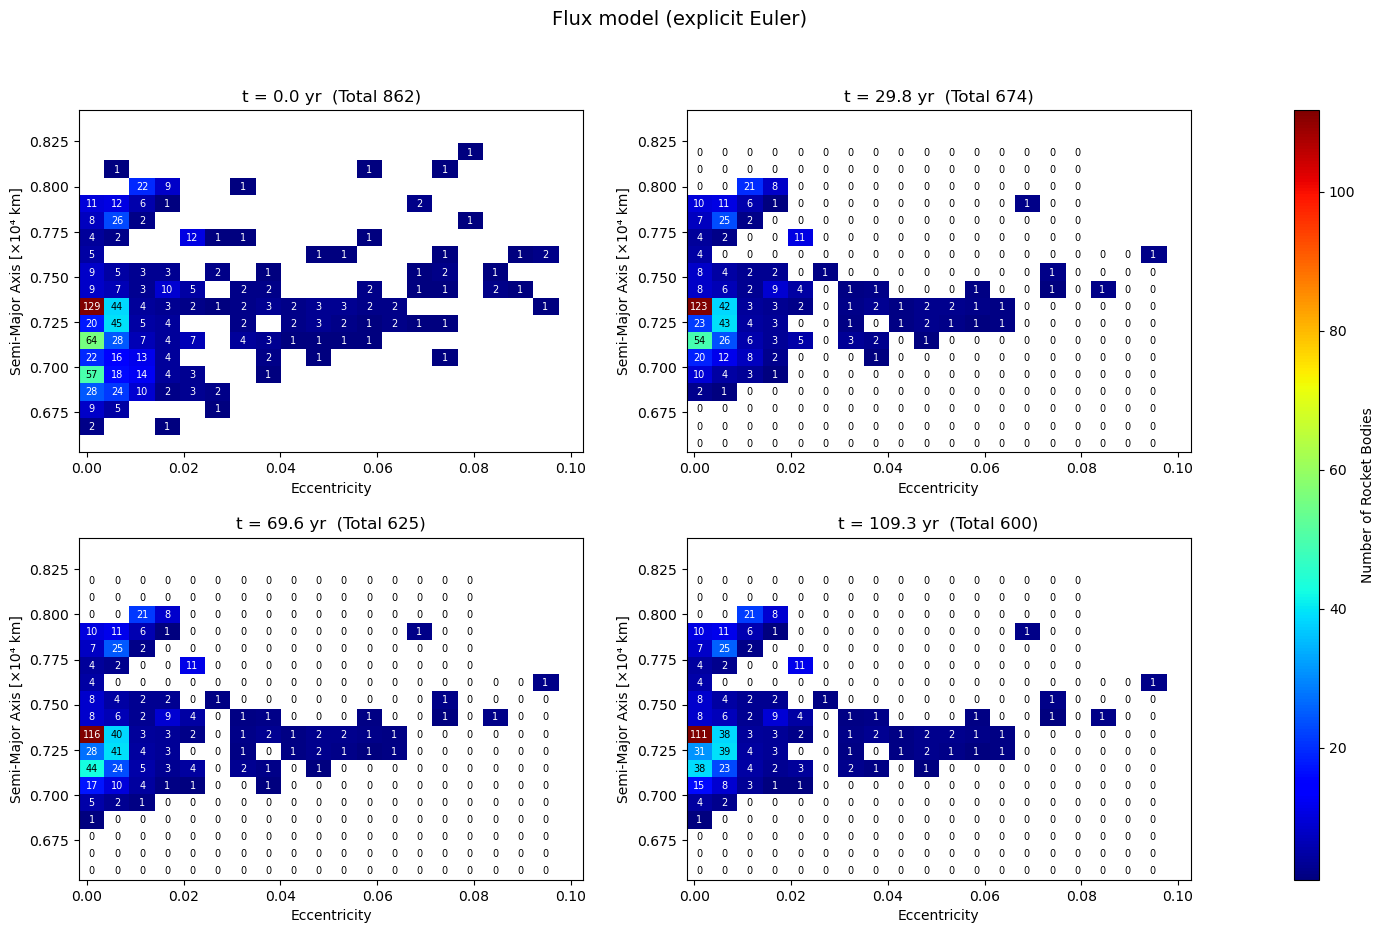

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np

# ───────────────────────────────────────────────────────────────
# snapshot indices and calendar times
# ───────────────────────────────────────────────────────────────
snap_idx   = np.linspace(0, len(N_hist) - 1, 4, dtype=int)
snap_years = snap_idx * store_every * dt / SECONDS_PER_YEAR
titles     = [f"t = {y:.1f} yr" for y in snap_years]

# grid-cell centres for label placement
x_centers = eccentricity_points
y_centers = semi_major_axis_points / 1e4    # km → ×10⁴ km axis

# jet colormap, white for zeros
cmap = cm.get_cmap('jet').copy()
cmap.set_under('white')

# ── figure layout: 2 × 2 panels + colour-bar ───────────────────
fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.05],
                        wspace=0.3, hspace=0.25)
axes    = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
cbar_ax = fig.add_subplot(gs[:, 2])

dx = eccentricity_points[1] - eccentricity_points[0]
dy = (semi_major_axis_points[1] - semi_major_axis_points[0]) / 1e4

x_left  = eccentricity_points[0] - dx / 2
x_right = eccentricity_points[-1] + dx / 2
y_bot   = semi_major_axis_points[0] / 1e4 - dy / 2
y_top   = semi_major_axis_points[-1] / 1e4 + dy / 2

# ── plot each snapshot ─────────────────────────────────────────
for p, idx in enumerate(snap_idx):
    ax  = axes[p]
    H   = N_hist[idx]
    Hm  = np.ma.masked_where(H == 0, H)

    vmax = max(1, Hm.max() if Hm.count() else 0)   # guar. ≥ vmin
    im = ax.imshow(
        Hm,
        extent=[x_left, x_right, y_bot, y_top],
        origin='lower', aspect='auto',
        cmap=cmap, vmin=1, vmax=vmax, interpolation='nearest')

    ax.set_title(f"{titles[p]}  (Total {H.sum():.0f})")
    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Semi-Major Axis [×10⁴ km]')

    norm = Normalize(vmin=1, vmax=vmax)
    for i in range(n_points):
        for j in range(n_points):
            val = H[i, j]
            if val:
                r, g, b, _ = cmap(norm(val))           # main cmap
                lum   = 0.299*r + 0.587*g + 0.114*b
                txt_c = 'black' if lum > 0.5 else 'white'
                ax.text(x_centers[j], y_centers[i], str(int(val)),
                        ha='center', va='center', fontsize=7, color=txt_c)

# shared colour-bar
fig.colorbar(im, cax=cbar_ax, label='Number of Rocket Bodies')
fig.suptitle('Flux model (explicit Euler)', fontsize=14)
plt.tight_layout()
plt.show()

## Comparison between the two

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/3455321174.py:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapS = cm.get_cmap('jet').copy()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_92230/3455321174.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.96,0.94])


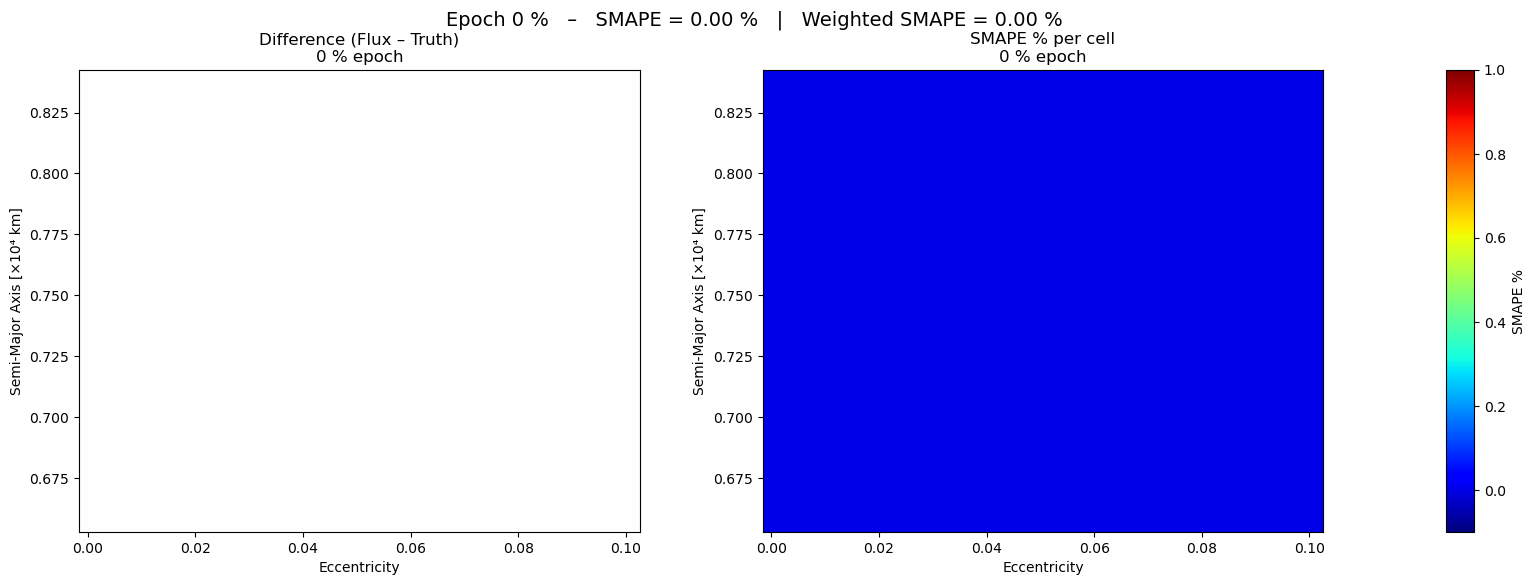

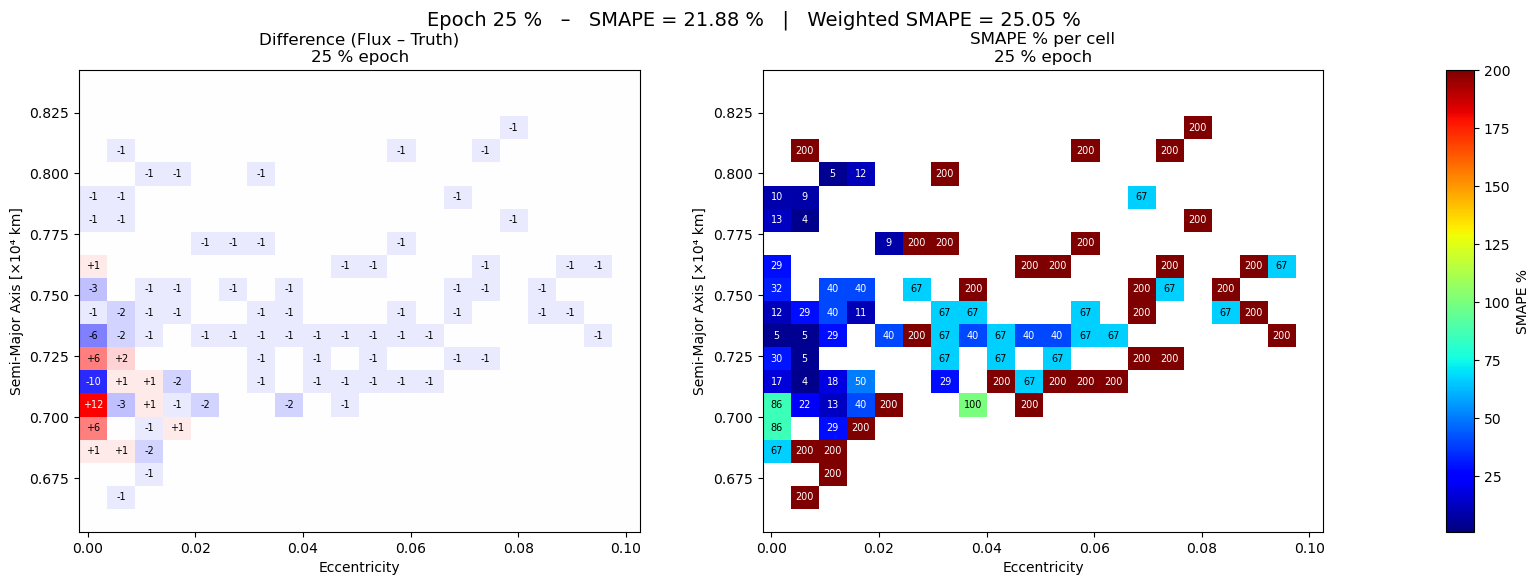

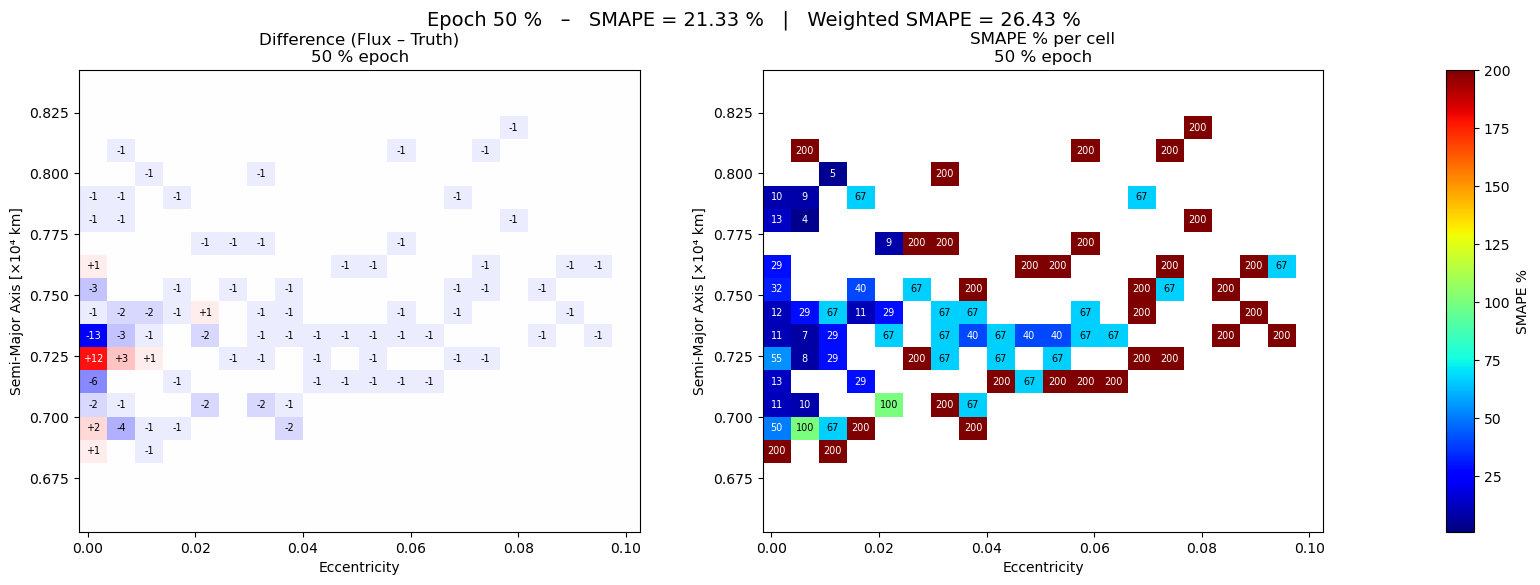

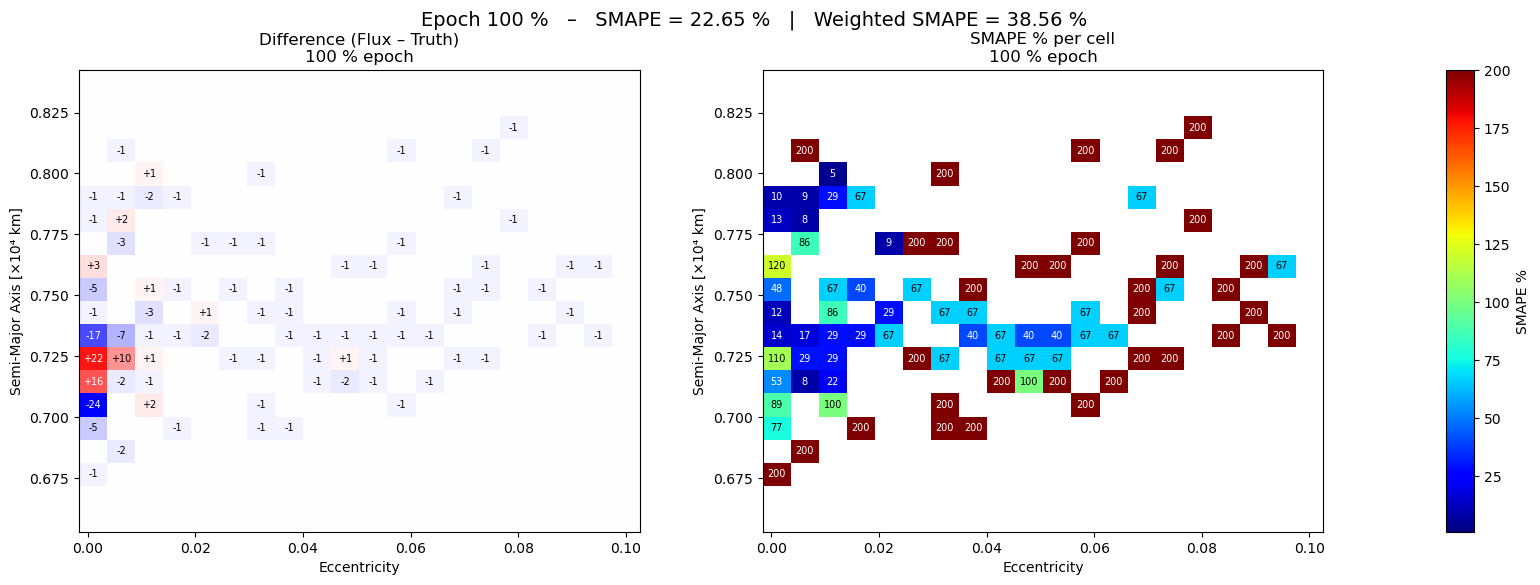

──────── Summary ────────
  0 %  •  per-cell SMAPE =   0.00%   weighted =   0.00%
 25 %  •  per-cell SMAPE =  21.88%   weighted =  25.05%
 50 %  •  per-cell SMAPE =  21.33%   weighted =  26.43%
100 %  •  per-cell SMAPE =  22.65%   weighted =  38.56%


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from matplotlib.colors import Normalize, TwoSlopeNorm

# ───────────────────────────────────────────────────────────────
# A. CONSTANTS & BIN HELPERS
# ───────────────────────────────────────────────────────────────
n_points = len(semi_major_axis_points)

dx = eccentricity_points[1] - eccentricity_points[0]
dy = (semi_major_axis_points[1] - semi_major_axis_points[0]) / 1e4

x_edges  = np.concatenate(([eccentricity_points[0] - dx/2],
                           eccentricity_points + dx/2))
y_edges  = np.concatenate(([semi_major_axis_points[0]/1e4 - dy/2],
                           semi_major_axis_points/1e4 + dy/2))

x_centres = eccentricity_points
y_centres = semi_major_axis_points / 1e4

# epoch indices
snap_idx = np.linspace(0, len(N_hist) - 1, 4, dtype=int) # flux history
time_idx_truth = [0,
                  int(0.25*(len(num_steps_times)-1)),
                  int(0.50*(len(num_steps_times)-1)),
                  int(1.00*(len(num_steps_times)-1))]

epochs_txt = ['0 %', '25 %', '50 %', '100 %']

# ───────────────────────────────────────────────────────────────
# B. BUILD MATCHED GRIDS
# ───────────────────────────────────────────────────────────────
truth_grids, flux_grids = [], []

for t_flux, t_truth in zip(snap_idx, time_idx_truth):

    flux_grid = N_hist[t_flux].astype(int)       # 20 × 20

    A = np.zeros((n_points, n_points), dtype=int)
    mask = (sma_trajectory_da_dt[:, t_truth] != -99) & \
           (ecc_trajectory_da_dt[:, t_truth] != -99)
    sma = sma_trajectory_da_dt[mask, t_truth]
    ecc = ecc_trajectory_da_dt[mask, t_truth]

    sma_idx = np.abs(semi_major_axis_points[:, None] - sma).argmin(axis=0)
    ecc_idx = np.abs(eccentricity_points[:,     None] - ecc).argmin(axis=0)
    np.add.at(A, (sma_idx, ecc_idx), 1)

    truth_grids.append(A)
    flux_grids.append(flux_grid)

# ───────────────────────────────────────────────────────────────
# C.  SMAPE (per-cell & weighted) + DIFFERENCE
# ───────────────────────────────────────────────────────────────
def smape(A, F):
    num = np.abs(A - F)
    den = np.abs(A) + np.abs(F)
    with np.errstate(divide='ignore', invalid='ignore'):
        cell = np.where(den > 0, 2*num/den, 0.0)
    return cell        # already multiplied by 2

diff_maps, smape_maps = [], []
overall_SM, overall_wSM = [], []

for A, F in zip(truth_grids, flux_grids):
    D  = F - A
    S  = smape(A, F)
    diff_maps.append(D)
    smape_maps.append(S)

    overall_SM.append( S.mean()*100 )                       # un-weighted
    w_tot = A.sum()
    overall_wSM.append( (S*A).sum() / w_tot * 100 if w_tot else np.nan )

# ───────────────────────────────────────────────────────────────
# D.  VISUALISATION LOOP
# ───────────────────────────────────────────────────────────────
for k in range(4):

    fig = plt.figure(figsize=(18, 6))
    gs  = gridspec.GridSpec(1, 3, width_ratios=[1,1,0.05], wspace=0.32)

    # -------- Difference map (Flux – Truth) --------------------
    ax1 = fig.add_subplot(gs[0,0])
    vmax = np.abs(diff_maps[k]).max()
    if vmax == 0:
        normD = Normalize(vmin=-1, vmax=1)
    else:
        normD = TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)

    im1 = ax1.imshow(diff_maps[k], extent=[x_edges[0], x_edges[-1],
                                           y_edges[0], y_edges[-1]],
                     origin='lower', aspect='auto',
                     cmap='bwr', norm=normD)

    ax1.set_title(f'Difference (Flux – Truth)\n{epochs_txt[k]} epoch')
    ax1.set_xlabel('Eccentricity')
    ax1.set_ylabel('Semi-Major Axis [×10⁴ km]')

    for i in range(n_points):
        for j in range(n_points):
            v = diff_maps[k][i, j]
            if v != 0:
                ax1.text(x_centres[j], y_centres[i], f'{v:+d}',
                         ha='center', va='center', fontsize=7,
                         color='white' if abs(v) > 0.5*vmax else 'black')

    # -------- SMAPE map ---------------------------------------
    ax2 = fig.add_subplot(gs[0,1])
    cmapS = cm.get_cmap('jet').copy()
    cmapS.set_under('white')
    im2 = ax2.imshow(smape_maps[k]*100, extent=[x_edges[0], x_edges[-1],
                                               y_edges[0], y_edges[-1]],
                     origin='lower', aspect='auto',
                     cmap=cmapS, vmin=1)

    ax2.set_title(f'SMAPE % per cell\n{epochs_txt[k]} epoch')
    ax2.set_xlabel('Eccentricity')
    ax2.set_ylabel('Semi-Major Axis [×10⁴ km]')

    normS = Normalize(vmin=1, vmax=(smape_maps[k]*100).max())
    for i in range(n_points):
        for j in range(n_points):
            val = smape_maps[k][i, j] * 100
            if val >= 1:
                r,g,b,_ = cmapS(normS(val))
                lum = 0.299*r + 0.587*g + 0.114*b
                ax2.text(x_centres[j], y_centres[i], f'{val:.0f}',
                         ha='center', va='center', fontsize=7,
                         color='black' if lum > 0.5 else 'white')

    # shared colour-bar
    cax = fig.add_subplot(gs[0,2])
    fig.colorbar(im2, cax=cax, label='SMAPE %')

    fig.suptitle(
        f'Epoch {epochs_txt[k]}   –   '
        f'SMAPE = {overall_SM[k]:.2f} %   |   '
        f'Weighted SMAPE = {overall_wSM[k]:.2f} %',
        fontsize=14)

    plt.tight_layout(rect=[0,0,0.96,0.94])
    plt.show()

# ───────────────────────────────────────────────────────────────
# E.  CONSOLE SUMMARY
# ───────────────────────────────────────────────────────────────
print('──────── Summary ────────')
for lab, u, w in zip(epochs_txt, overall_SM, overall_wSM):
    print(f'{lab:>5}  •  per-cell SMAPE = {u:6.2f}%   '
          f'weighted = {w:6.2f}%')


GLOBAL SCALAR METRICS
  0 %  RMSE=0.00  MAE=0.00  χ²=0.0  EMD=0.00
 25 %  RMSE=1.08  MAE=0.33  χ²=2000000082.1  EMD=0.23
 50 %  RMSE=1.11  MAE=0.32  χ²=1000000065.9  EMD=0.26
100 %  RMSE=2.19  MAE=0.48  χ²=157.7  EMD=0.28


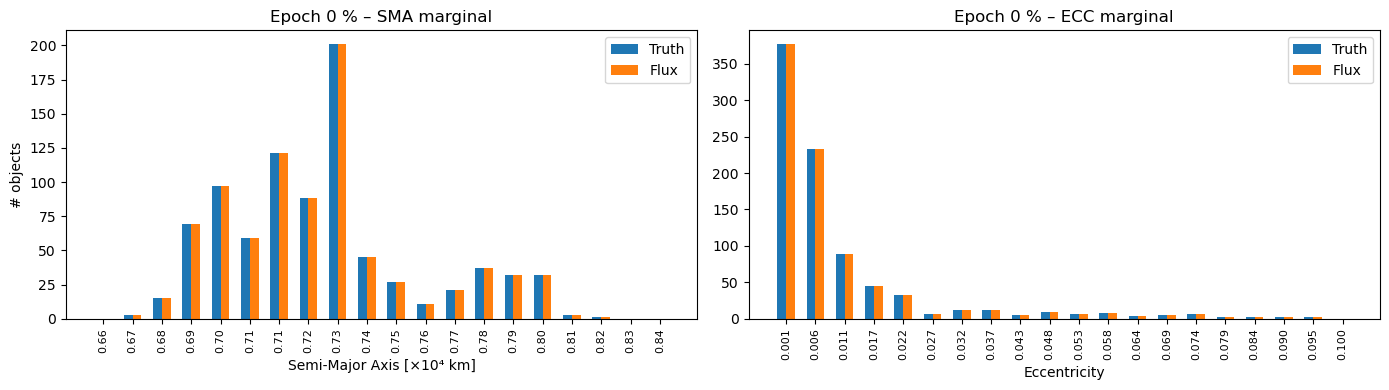

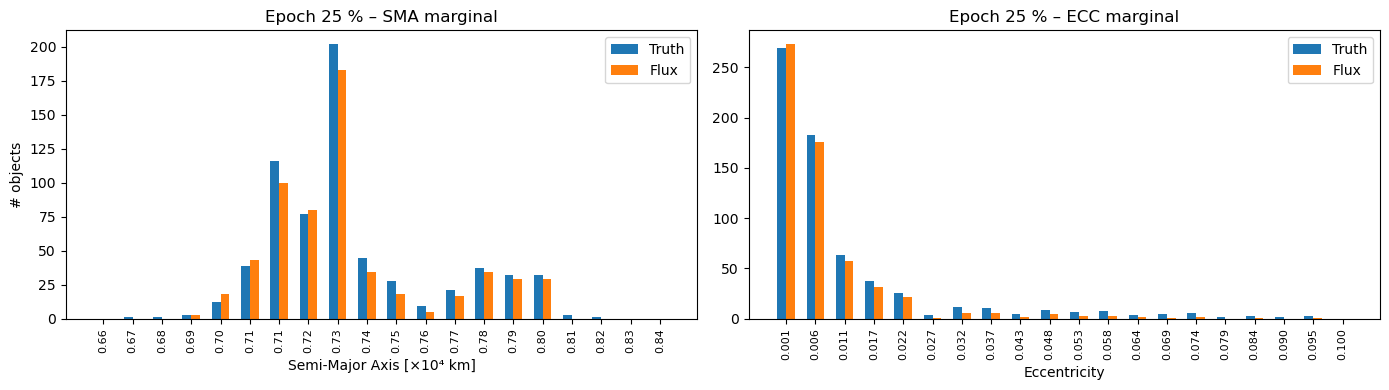

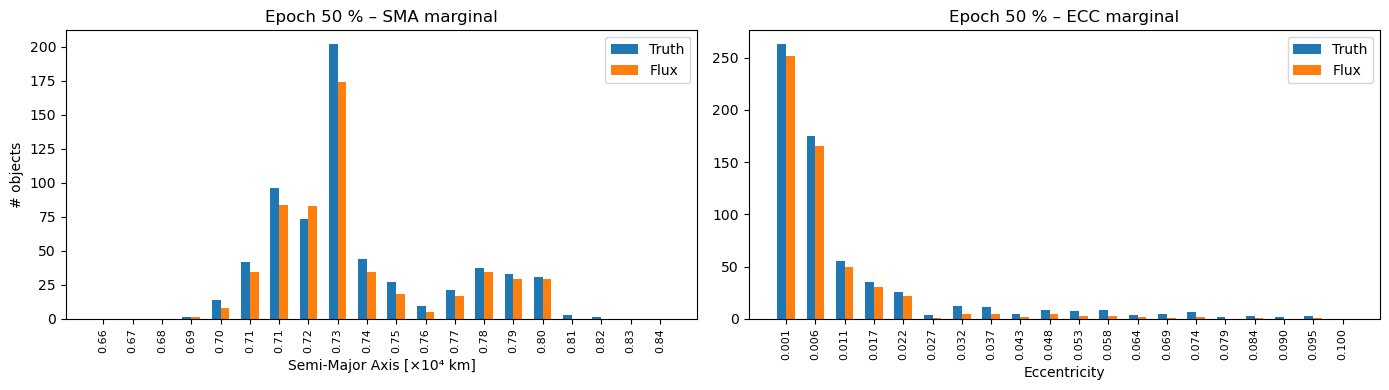

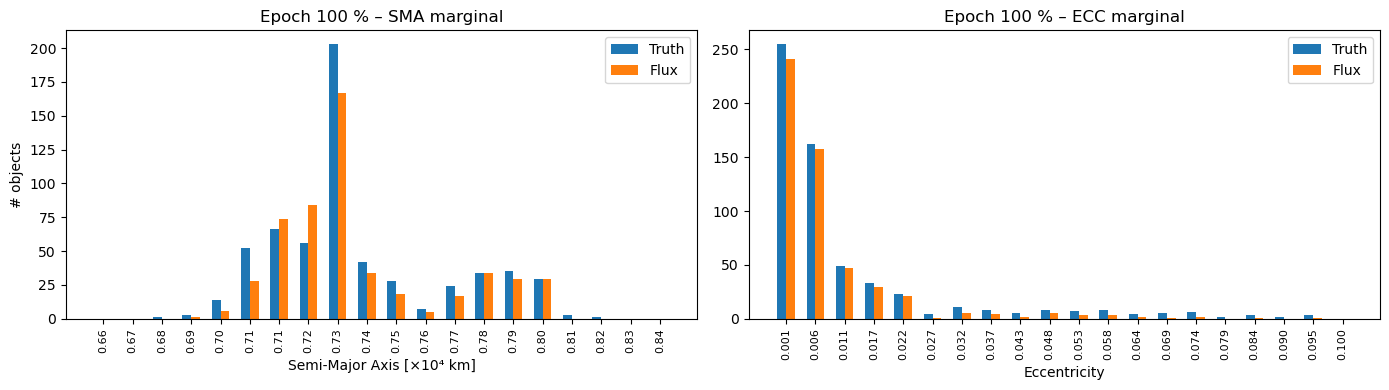

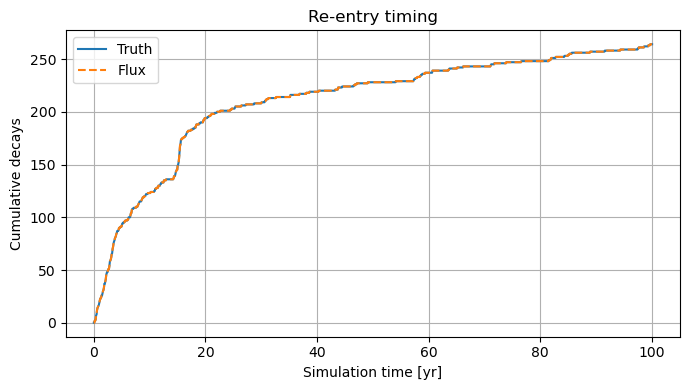

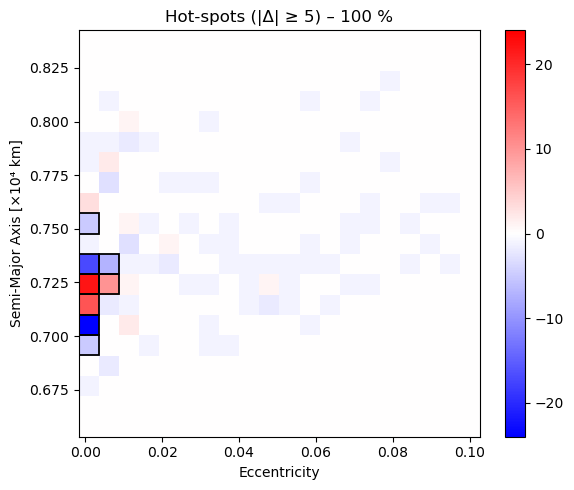

  0 %  •  grid-to-grid Pearson r = 1.000
 25 %  •  grid-to-grid Pearson r = 0.992
 50 %  •  grid-to-grid Pearson r = 0.993
100 %  •  grid-to-grid Pearson r = 0.959
Saved → difference_evolution.gif


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation, patches
from matplotlib.colors import Normalize, TwoSlopeNorm
from scipy.stats import wasserstein_distance, pearsonr
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

def rmse(A, B): return np.sqrt(((A - B)**2).mean())
def mae (A, B): return np.abs(A - B).mean()

scalar_metrics = []

for k, (A, F) in enumerate(zip(truth_grids, flux_grids), start=1):
    chi2 = np.where(A + 1e-9, ((F - A)**2) / (A + 1e-9), 0).sum()
    emd  = wasserstein_distance(A.ravel(), F.ravel())
    scalar_metrics.append(dict(epoch=epochs_txt[k-1],
                               RMSE=rmse(A, F),
                               MAE =mae (A, F),
                               Chi2=chi2,
                               EMD =emd))

print('\nGLOBAL SCALAR METRICS')
for d in scalar_metrics:
    print(f"{d['epoch']:>5}  RMSE={d['RMSE']:.2f}  MAE={d['MAE']:.2f}  "
          f"χ²={d['Chi2']:.1f}  EMD={d['EMD']:.2f}")
    

# ───────────────────────────────────────────────────────────────
for k, (A, F) in enumerate(zip(truth_grids, flux_grids)):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

    # SMA marginal
    ax[0].bar(np.arange(n_points)-0.15, A.sum(axis=1), width=0.3, label='Truth')
    ax[0].bar(np.arange(n_points)+0.15, F.sum(axis=1), width=0.3, label='Flux')
    ax[0].set_xticks(np.arange(n_points))
    ax[0].set_xticklabels([f'{a/1e4:.2f}' for a in semi_major_axis_points],
                          rotation=90, fontsize=8)
    ax[0].set_title(f'Epoch {epochs_txt[k]} – SMA marginal')
    ax[0].set_xlabel('Semi-Major Axis [×10⁴ km]'); ax[0].set_ylabel('# objects')
    ax[0].legend()

    # ECC marginal
    ax[1].bar(np.arange(n_points)-0.15, A.sum(axis=0), width=0.3, label='Truth')
    ax[1].bar(np.arange(n_points)+0.15, F.sum(axis=0), width=0.3, label='Flux')
    ax[1].set_xticks(np.arange(n_points))
    ax[1].set_xticklabels([f'{e:.3f}' for e in eccentricity_points],
                          rotation=90, fontsize=8)
    ax[1].set_title(f'Epoch {epochs_txt[k]} – ECC marginal')
    ax[1].set_xlabel('Eccentricity'); ax[1].legend()

    fig.tight_layout(); plt.show()

reentry_truth = []       # cumulative # decayed up to each step
reentry_flux  = []

for step in range(len(num_steps_times)):
    t_mask = (sma_trajectory_da_dt[:, step] == -99)
    f_mask = (sma_trajectory[:, step]     == -99)   # flux or original?
    reentry_truth.append(t_mask.sum())
    reentry_flux.append(f_mask.sum())

plt.figure(figsize=(7,4))
plt.plot(num_steps_times/SECONDS_PER_YEAR, reentry_truth, label='Truth')
plt.plot(num_steps_times/SECONDS_PER_YEAR, reentry_flux,  label='Flux', ls='--')
plt.xlabel('Simulation time [yr]'); plt.ylabel('Cumulative decays')
plt.title('Re-entry timing'); plt.grid(); plt.legend(); plt.tight_layout()


delta_threshold = 5        # cells differing by ≥5 objects

k = 3                      # epoch index (0…3) to show
D = diff_maps[k]

fig, ax = plt.subplots(figsize=(6,5))
norm = TwoSlopeNorm(vcenter=0, vmin=-np.abs(D).max(), vmax=np.abs(D).max())
im   = ax.imshow(D, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                 origin='lower', aspect='auto', cmap='bwr', norm=norm)

# outline hotspots
for i in range(n_points):
    for j in range(n_points):
        if abs(D[i,j]) >= delta_threshold:
            rect = patches.Rectangle((x_edges[j], y_edges[i]),
                                     dx, dy, linewidth=1.3,
                                     edgecolor='black', facecolor='none')
            ax.add_patch(rect)

ax.set_title(f'Hot-spots (|Δ| ≥ {delta_threshold}) – {epochs_txt[k]}')
ax.set_xlabel('Eccentricity'); ax.set_ylabel('Semi-Major Axis [×10⁴ km]')
plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

for lab, A, F in zip(epochs_txt, truth_grids, flux_grids):
    r, _ = pearsonr(A.ravel(), F.ravel())
    print(f'{lab:>5}  •  grid-to-grid Pearson r = {r:.3f}')

fig, ax = plt.subplots(figsize=(6,5))
norm = TwoSlopeNorm(vcenter=0, vmin=-np.max(np.abs(diff_maps)),
                    vmax= np.max(np.abs(diff_maps)))
cmap = 'bwr'
txt  = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='w', fontsize=12)
im   = ax.imshow(diff_maps[0], extent=[x_edges[0], x_edges[-1],
                                       y_edges[0], y_edges[-1]],
                 origin='lower', aspect='auto', cmap=cmap, norm=norm)
ax.set_xlabel('Eccentricity'); ax.set_ylabel('SMA [×10⁴ km]')

def update(frame):
    im.set_data(diff_maps[frame])
    txt.set_text(f'{epochs_txt[frame]}')
    return im, txt

ani = animation.FuncAnimation(fig, update, frames=4, interval=1200, blit=True)
ani.save('difference_evolution.gif', writer='pillow')
plt.close(fig)
print('Saved → difference_evolution.gif')